# **Importing Libraries**

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

import warnings

warnings.filterwarnings('ignore')

# **Importing Dataset**

In [ ]:
file_path = "loan_data_2007_2014.csv"
import csv
df = pd.read_csv(file_path, on_bad_lines='warn')
df.head()

Unnamed: 0       id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0           0  1077501    1296599       5000         5000           4975.0   
1           1  1077430    1314167       2500         2500           2500.0   
2           2  1077175    1313524       2400         2400           2400.0   
3           3  1076863    1277178      10000        10000          10000.0   
4           4  1075358    1311748       3000         3000           3000.0   

         term  int_rate  installment grade  ... total_bal_il il_util  \
0   36 months     10.65       162.87     B  ...          NaN     NaN   
1   60 months     15.27        59.83     C  ...          NaN     NaN   
2   36 months     15.96        84.33     C  ...          NaN     NaN   
3   36 months     13.49       339.31     C  ...          NaN     NaN   
4   60 months     12.69        67.79     B  ...          NaN     NaN   

  open_rv_12m open_rv_24m  max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         NaN         NaN         NaN      NaN              NaN    NaN   
1         NaN         NaN         NaN      NaN              NaN    NaN   
2         NaN         NaN         NaN      NaN              NaN    NaN   
3         NaN         NaN         NaN      NaN              NaN    NaN   
4         NaN         NaN         NaN      NaN              NaN    NaN   

  total_cu_tl inq_last_12m  
0         NaN          NaN  
1         NaN          NaN  
2         NaN          NaN  
3         NaN          NaN  
4         NaN          NaN  

[5 rows x 75 columns]

# **Data Understanding**

In [ ]:
# Menampilkan jumlah baris dan kolom dalam dataset
print(f"Jumlah baris dan kolom: {df.shape[0]} baris, {df.shape[1]} kolom\n")

# Menampilkan informasi tipe data setiap kolom
print("Tipe data setiap kolom:")
df.info()

# Menampilkan tipe data setiap kolom
print("\nJenis Data pada setiap kolom:")
print(df.dtypes)

# Menampilkan ringkasan statistik deskriptif
print("\nJenis Persebaran data pada setiap kolom:")
print(df.describe())

# Melihat nilai nunique pada dataset
print("\nJumlah nilai unik pada setiap kolom:")
print(df.nunique())

Jumlah baris dan kolom: 466285 baris, 75 kolom

Tipe data setiap kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null 

Dataset memiliki 466285  baris dan 75 kolom.
Mayoritas kolom bertipe object (54 kolom) dan sisanya float64 (21 kolom).
Beberapa masalah yang terlihat:

- Banyak *missing values*, terutama di beberapa kolom dengan jumlah *non-null* sangat rendah (misalnya, open_il_6m, inq_last_12m).

- Kolom numerik tersimpan sebagai *object*, seperti loan_amnt, funded_amnt, dan int_rate, yang perlu dikonversi.

- Kolom dengan nilai nol atau hampir kosong, seperti open_il_6m dan inq_last_12m.

In [ ]:
# Analisis Data yang Tidak Lengkap dan Duplikat
print("=== ANALISIS KELENGKAPAN DATA ===")
print("Jumlah nilai yang hilang per kolom:")
print(df.isnull().sum())

print("\n=== ANALISIS DUPLIKASI DATA ===")
print(f"Jumlah baris duplikat: {df.duplicated().sum()}")

=== ANALISIS KELENGKAPAN DATA ===
Jumlah nilai yang hilang per kolom:
Unnamed: 0               0
id                       0
member_id                0
loan_amnt                0
funded_amnt              0
                     ...  
all_util            466285
total_rev_hi_lim     70276
inq_fi              466285
total_cu_tl         466285
inq_last_12m        466285
Length: 75, dtype: int64

=== ANALISIS DUPLIKASI DATA ===
Jumlah baris duplikat: 0


Dari hasil analisis kelengkapan data:

1. Data Hilang:

- Ada beberapa kolom dengan nilai yang hilang, terutama pada kolom all_util, total_rev_hi_lim, inq_fi, total_cu_tl, dan inq_last_12m, masing-masing memiliki 22.617 nilai yang hilang.

2. Duplikasi Data:

- Tidak ditemukan baris duplikat dalam dataset (Jumlah baris duplikat: 0), yang berarti data tidak memiliki masalah penggandaan.

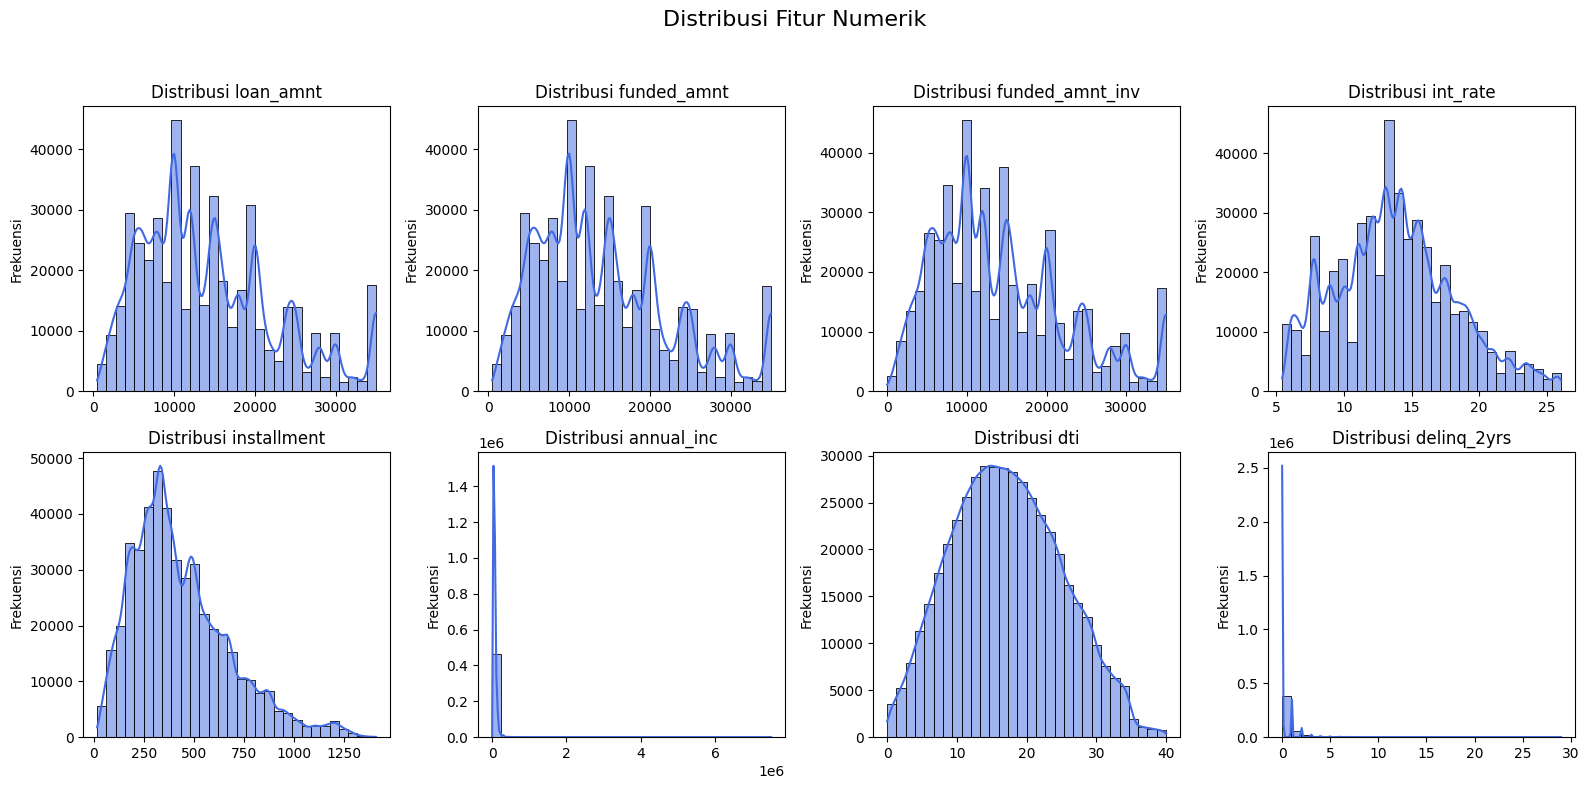

In [ ]:
# Memilih fitur numerik untuk melihat distribusi data
selected_features = [
    'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
    'installment', 'annual_inc', 'dti', 'delinq_2yrs'
]

# Mengonversi kolom ke tipe numerik untuk menghindari error
for col in selected_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Mengubah nilai non-numerik menjadi NaN

# Menghapus baris yang memiliki NaN setelah konversi
df_cleaned = df.dropna(subset=selected_features)

# Visualisasi Distribusi Fitur (Histogram)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Distribusi Fitur Numerik", fontsize=16)

for ax, col in zip(axes.flatten(), selected_features):
    sns.histplot(df_cleaned[col], bins=30, kde=True, ax=ax, color="royalblue")
    ax.set_title(f"Distribusi {col}")
    ax.set_xlabel("")
    ax.set_ylabel("Frekuensi")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

1. loan_amnt, funded_amnt, funded_amnt_inv → Distribusi miring ke kanan, mayoritas pinjaman berkisar 5.000–15.000 dengan beberapa outlier di atas 30.000.

2. int_rate → Mayoritas suku bunga 10–15%, dengan beberapa pinjaman memiliki bunga lebih tinggi.

3. installment → Sebagian besar angsuran bulanan 200–500, dengan sedikit outlier di atas 1.000.

4. annual_inc → Sangat skewed ke kanan, mayoritas pendapatan di bawah 100.000, beberapa outlier di atas 500.000.

5. dti → Distribusi mendekati normal, dengan mayoritas rasio utang terhadap pendapatan di kisaran 10–20.

6. delinq_2yrs → Mayoritas peminjam tidak memiliki tunggakan, hanya sedikit yang memiliki lebih dari satu tunggakan dalam 2 tahun terakhir.

# **Exploratory Data Analysis (EDA)**

=== ANALISIS DISTRIBUSI DATA ===


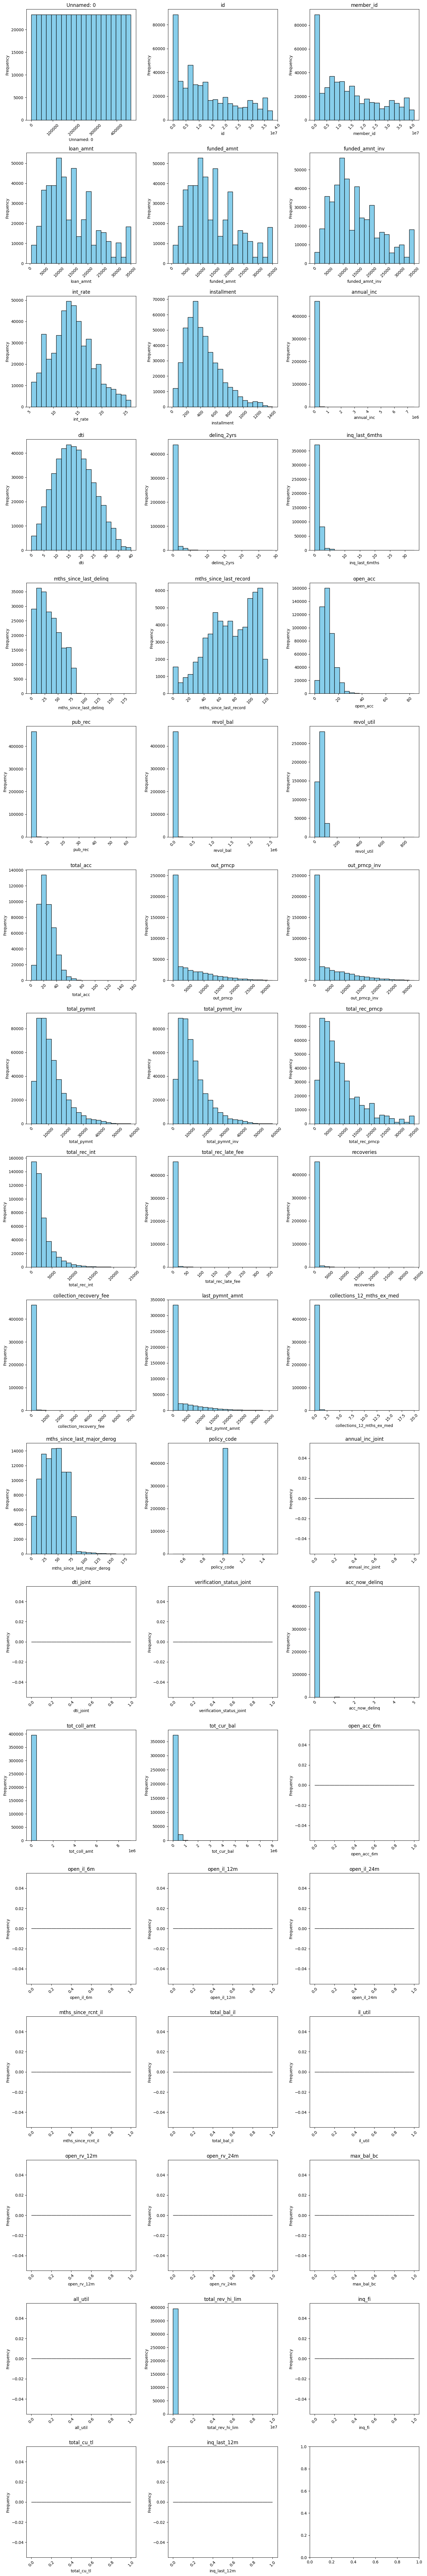

In [ ]:
print("=== ANALISIS DISTRIBUSI DATA ===")

# Memilih kolom numerik
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Menentukan jumlah baris dan kolom untuk layout
rows = len(num_cols) // 3 + (1 if len(num_cols) % 3 != 0 else 0)

# Membuat histogram untuk setiap kolom numerik
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

# Plotting histogram untuk setiap kolom numerik
for i, col in enumerate(num_cols):
    axes[i].hist(df[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=45)  # Rotasi label sumbu X agar tidak berantakan

# Menyesuaikan layout agar tidak tumpang tindih
plt.tight_layout()
plt.show()

1. Beberapa fitur memiliki distribusi normal, seperti debt-to-income ratio (DTI) yang membentuk pola simetris.

2. Beberapa fitur memiliki skewed distribution (miring ke kanan), seperti annual income dan loan amount, menunjukkan sebagian besar data berada di nilai yang lebih rendah dengan sedikit outlier di rentang yang lebih tinggi.

3. Fitur kategorikal memiliki distribusi yang tidak merata, di mana beberapa kategori mendominasi data, misalnya employment length dan loan status.

4. Beberapa fitur hampir tidak memiliki variasi, terlihat dari histogram yang hanya memiliki satu atau dua bar dominan, menunjukkan kemungkinan fitur tersebut kurang informatif atau perlu ditangani lebih lanjut.

5. Adanya fitur dengan banyak nilai nol atau mendekati nol, yang mungkin menunjukkan bahwa variabel tersebut jarang terjadi atau memiliki data sparse.

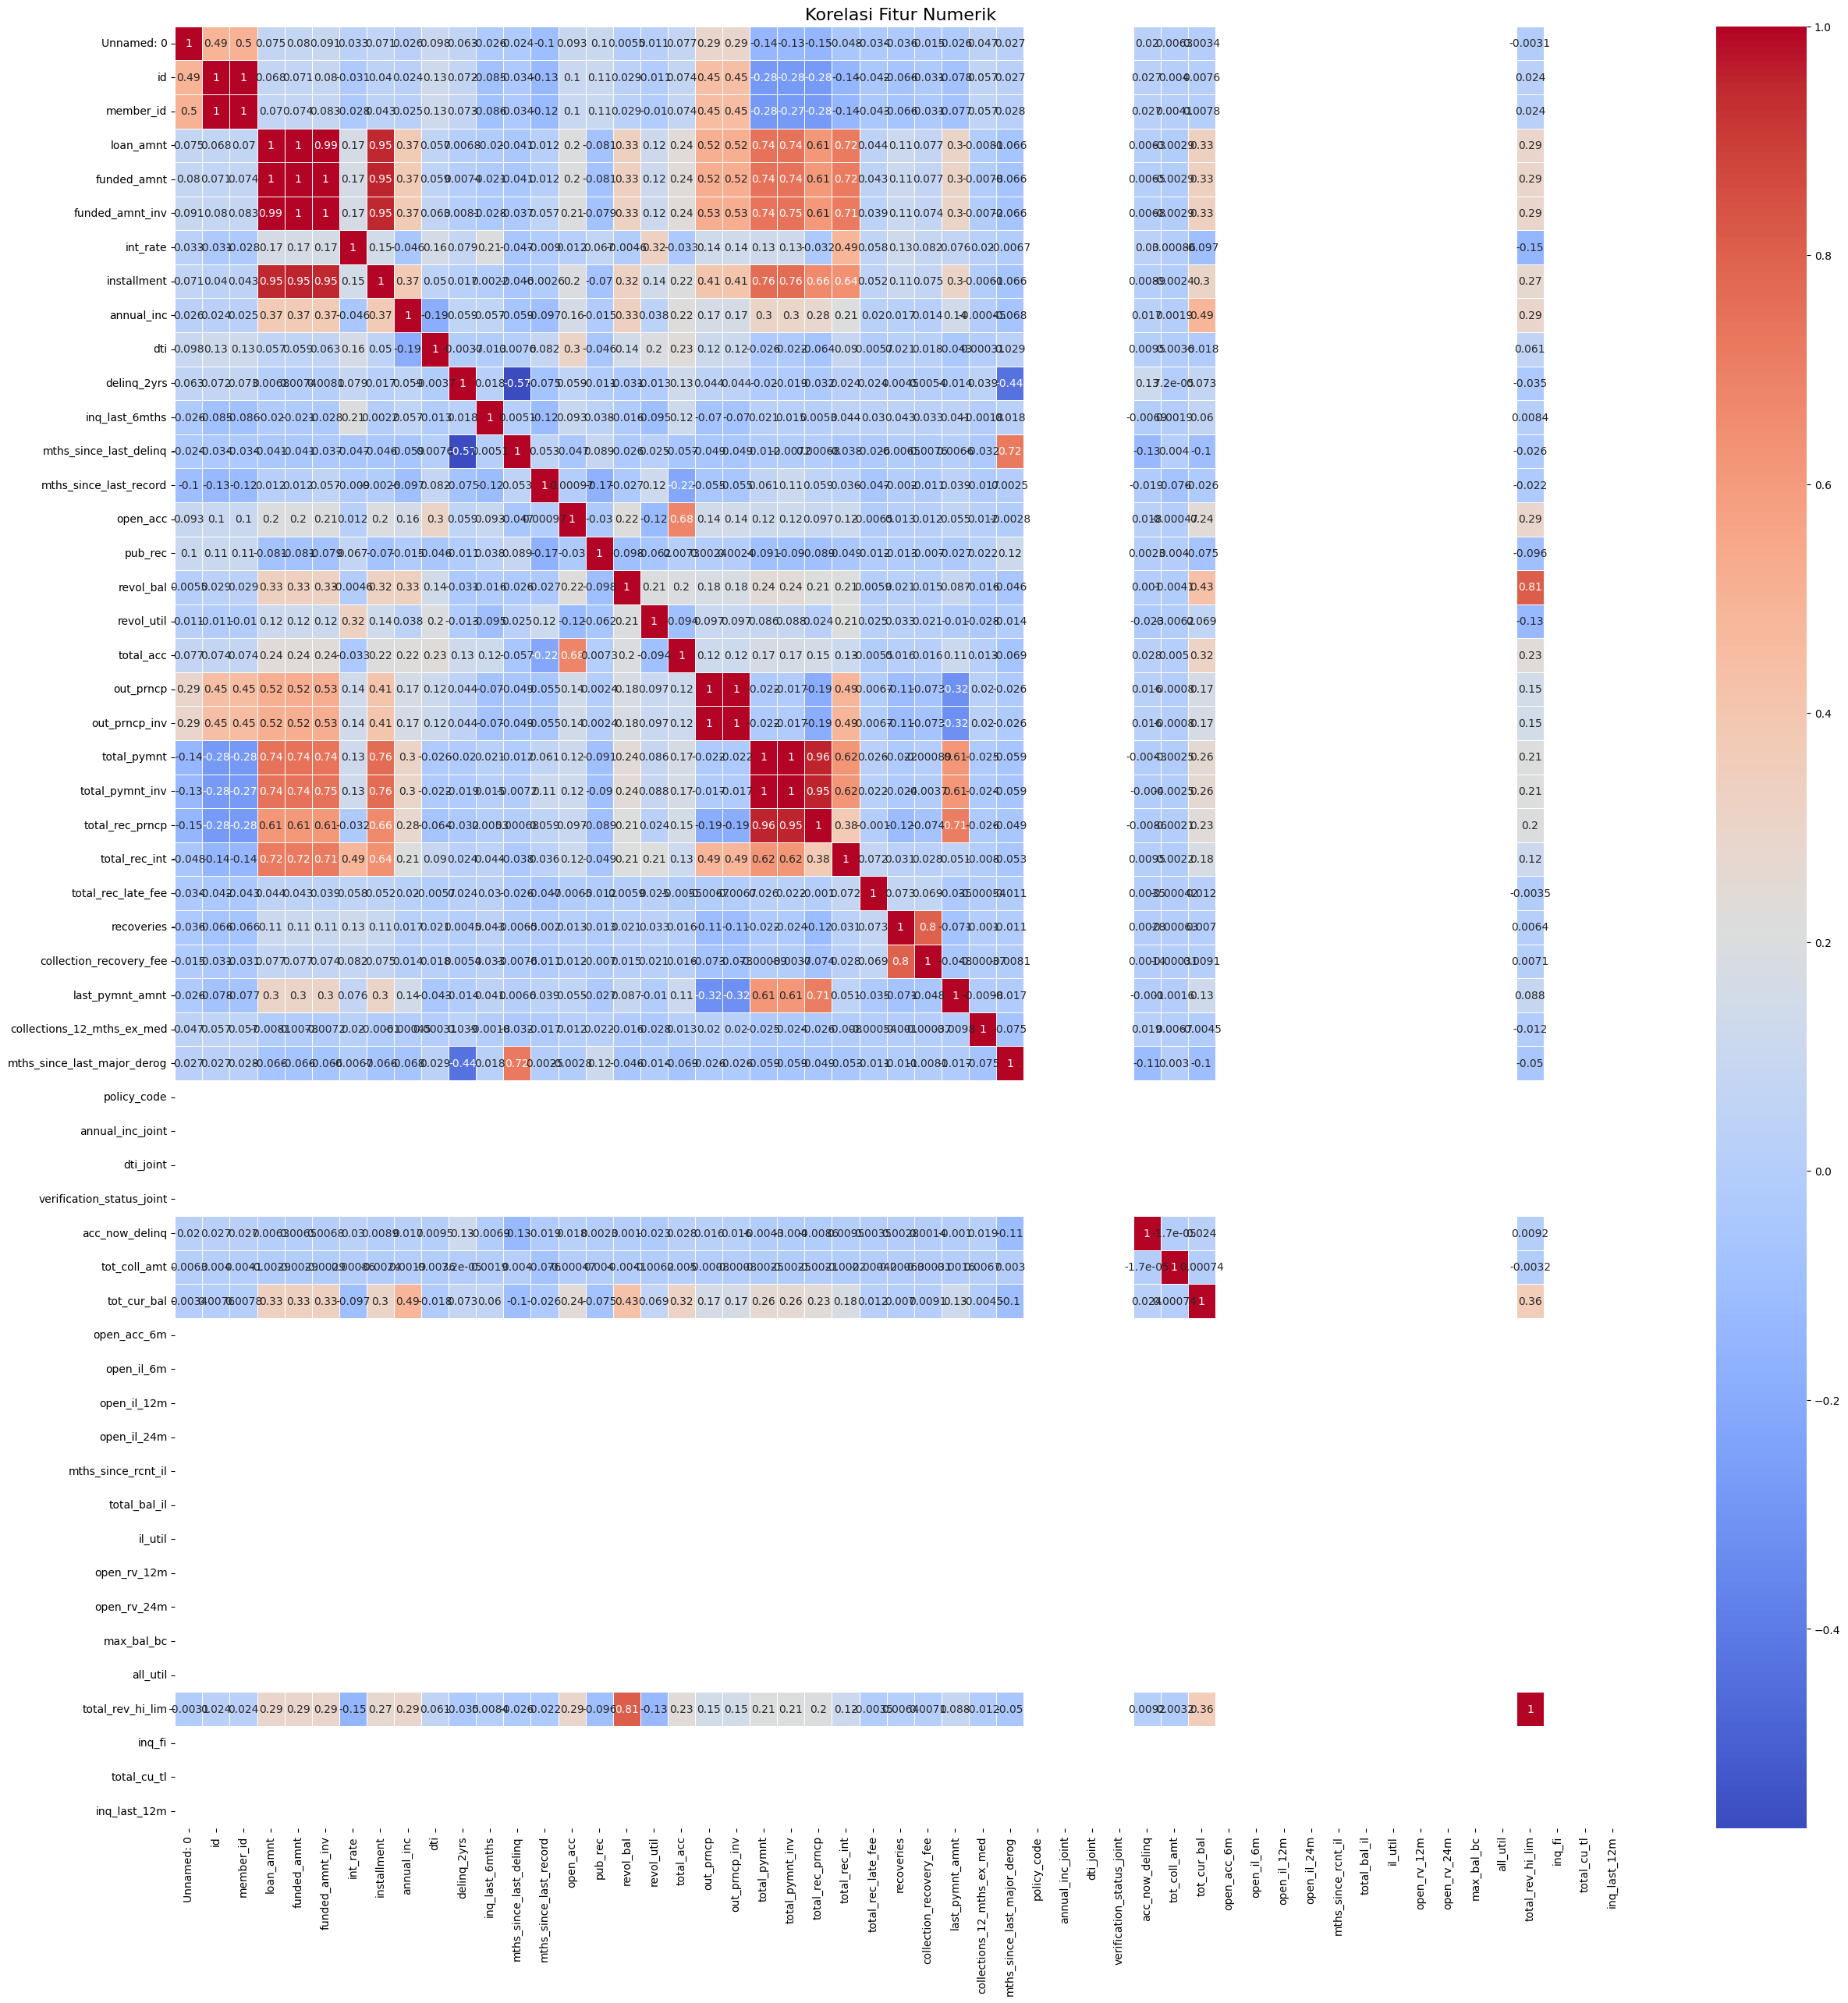

In [ ]:
# Menampilkan korelasi fitur dengan heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Korelasi Fitur Numerik", fontsize=16)
plt.show()

Berdasarkan *correlation heatmap*, terdapat beberapa fitur dengan korelasi tinggi terhadap *loan_status*. Untuk menghindari multikolinearitas, fitur-fitur tersebut akan dieliminasi dengan menggunakan ambang batas korelasi sebesar 0.7 dan akan di-*drop* pada tahap *data preparation*.

=== ANALISIS OUTLIERS ===


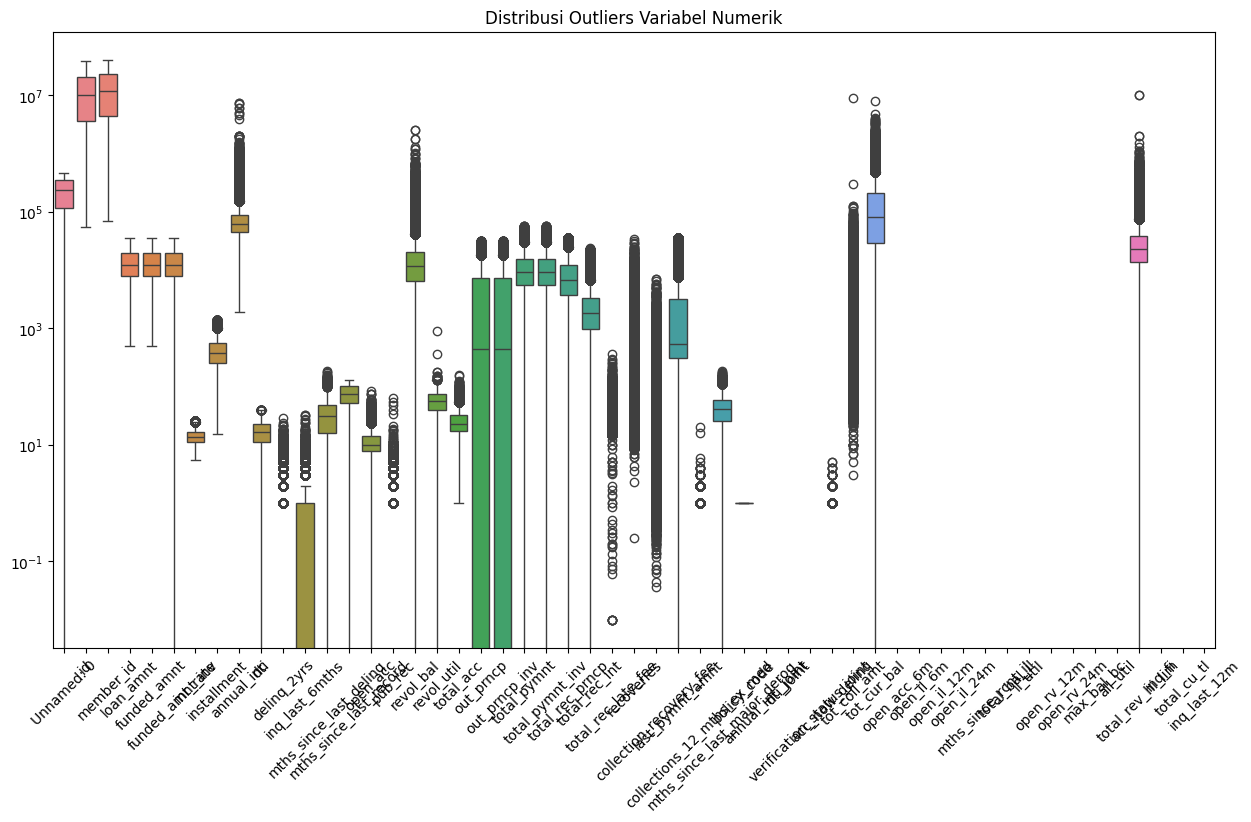

In [ ]:
# Menampilkan Distribusi Outliers variabel numerik dengan Boxplot
print("=== ANALISIS OUTLIERS ===")

# Membuat Boxplot untuk setiap kolom numerik
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[num_cols], whis=1.5)
plt.xticks(rotation=45)

# Tambahkan skala log jika diperlukan (opsional)
plt.yscale('log')

plt.title("Distribusi Outliers Variabel Numerik")
plt.show()

Berdasarkan boxplot distribusi outlier variabel numerik pada gambar:

1. Banyak variabel memiliki outlier yang signifikan, terlihat dari titik-titik di luar whisker yang menunjukkan adanya nilai ekstrem.

2. Variabel seperti loan_amnt, funded_amnt, dan installment memiliki distribusi yang cukup terpusat, tetapi tetap mengandung beberapa outlier.

3. Beberapa variabel dengan rentang data besar, seperti total_rec_prncp dan total_pymnt, memiliki banyak outlier yang tersebar luas.

4. Beberapa variabel memiliki distribusi yang sangat terdistorsi, ditunjukkan oleh whisker yang panjang dan banyaknya outlier, seperti annual_inc dan revol_bal.

5. Beberapa variabel memiliki nilai hampir konstan, ditandai dengan boxplot yang sangat kecil atau hampir tidak ada whisker, menunjukkan kurangnya variasi dalam data.

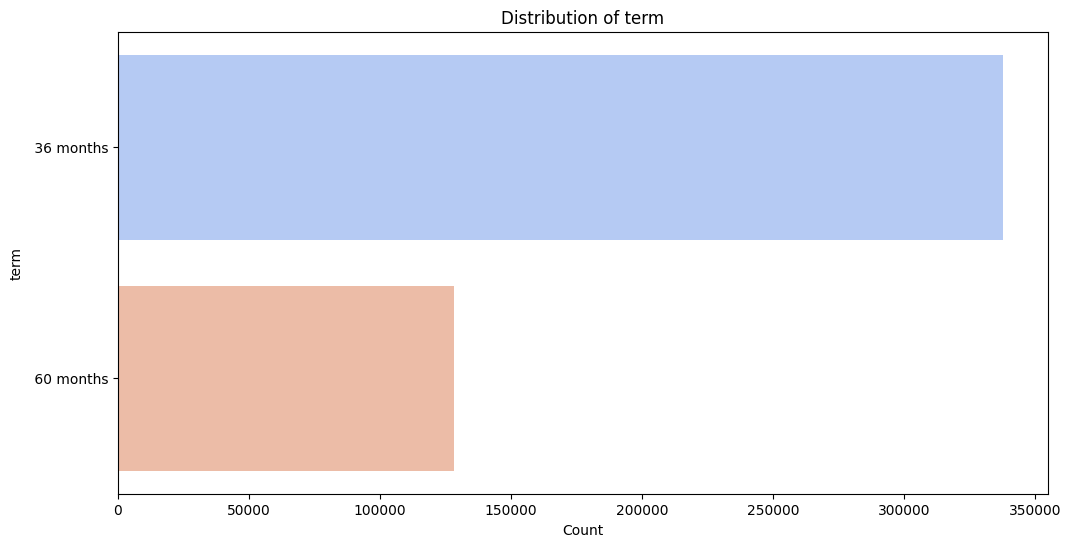

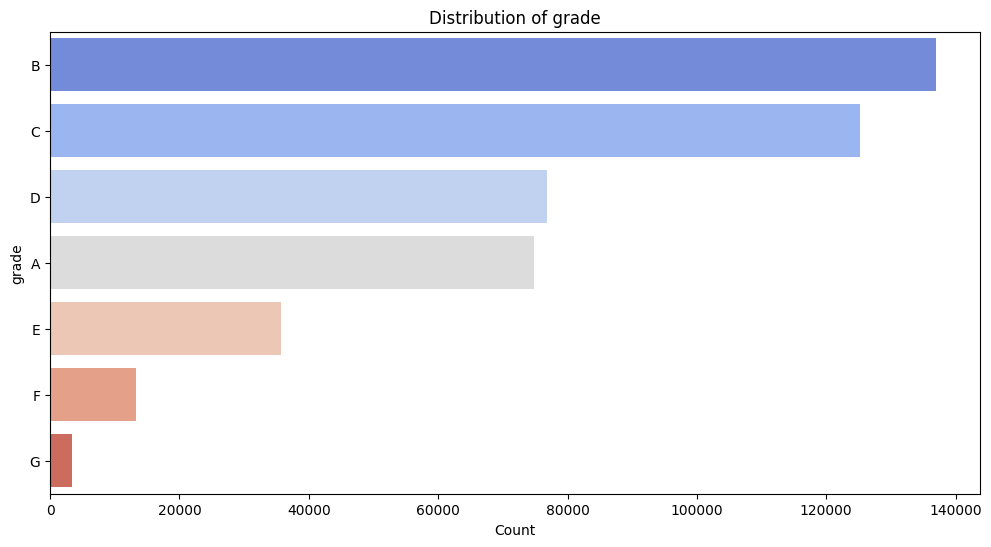

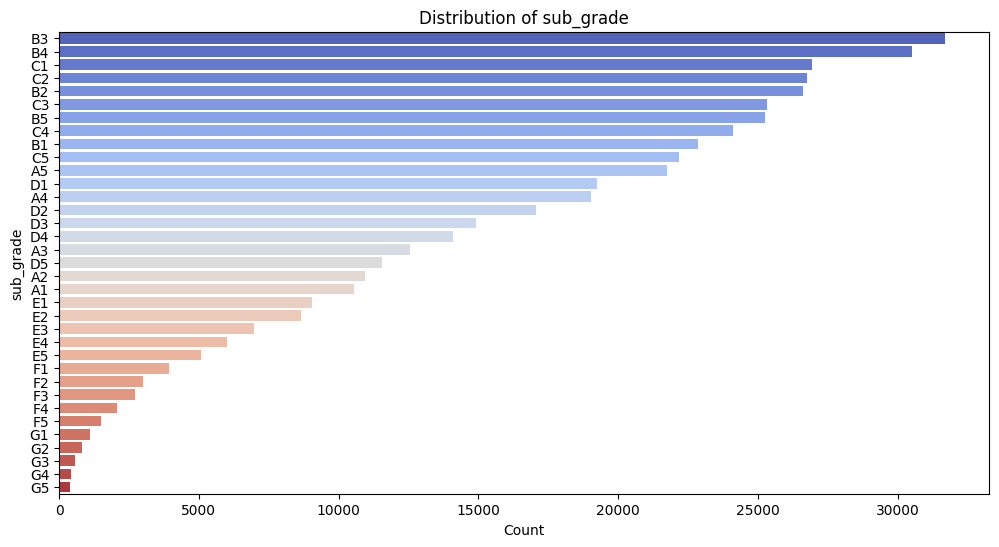

Kolom 'emp_title' memiliki banyak kategori unik (205475), hanya menampilkan 10 teratas.


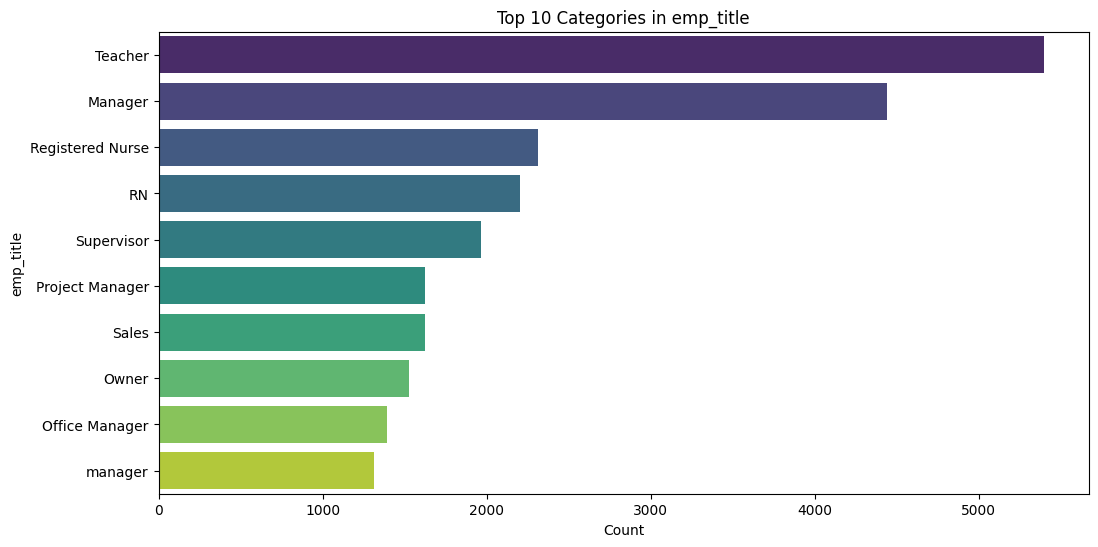

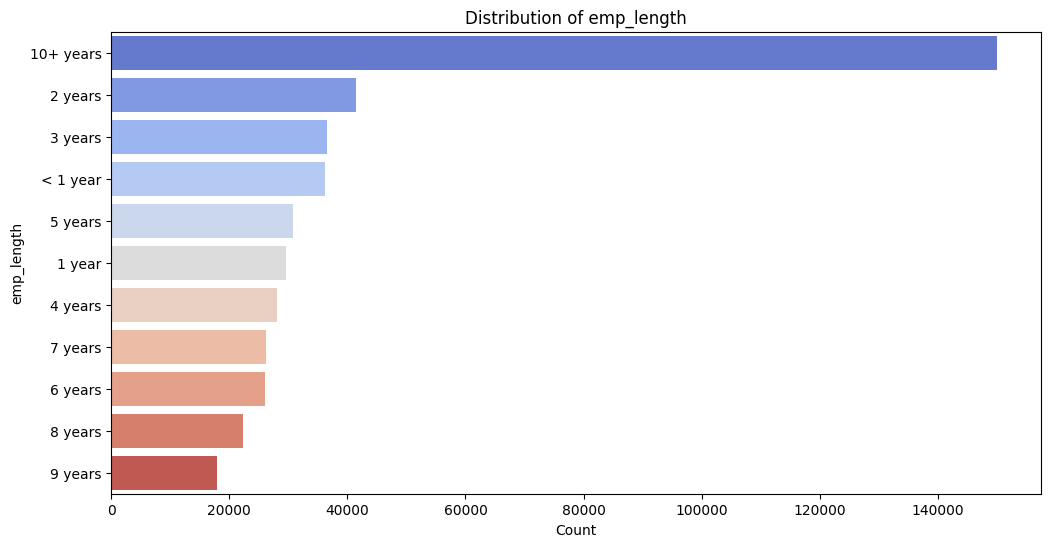

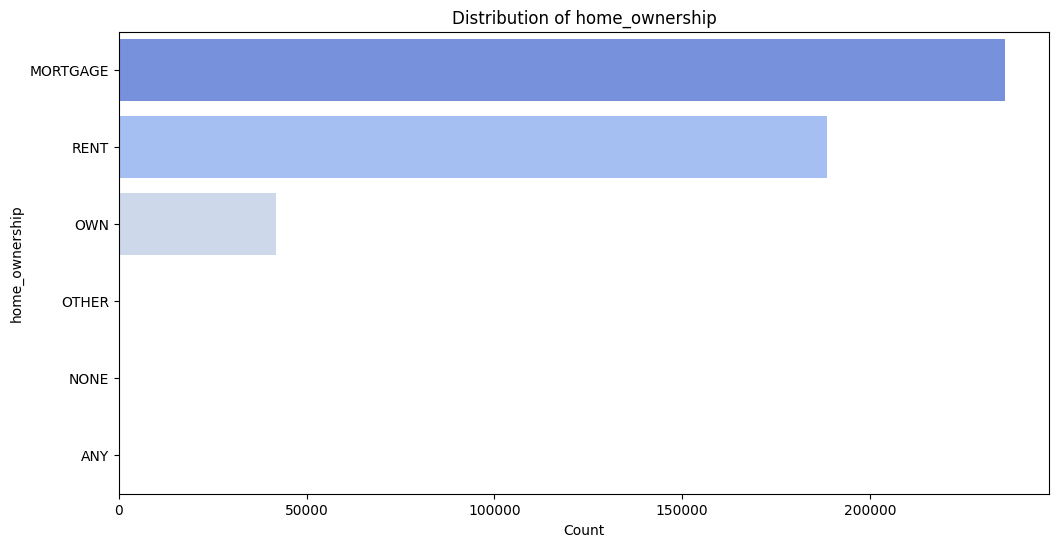

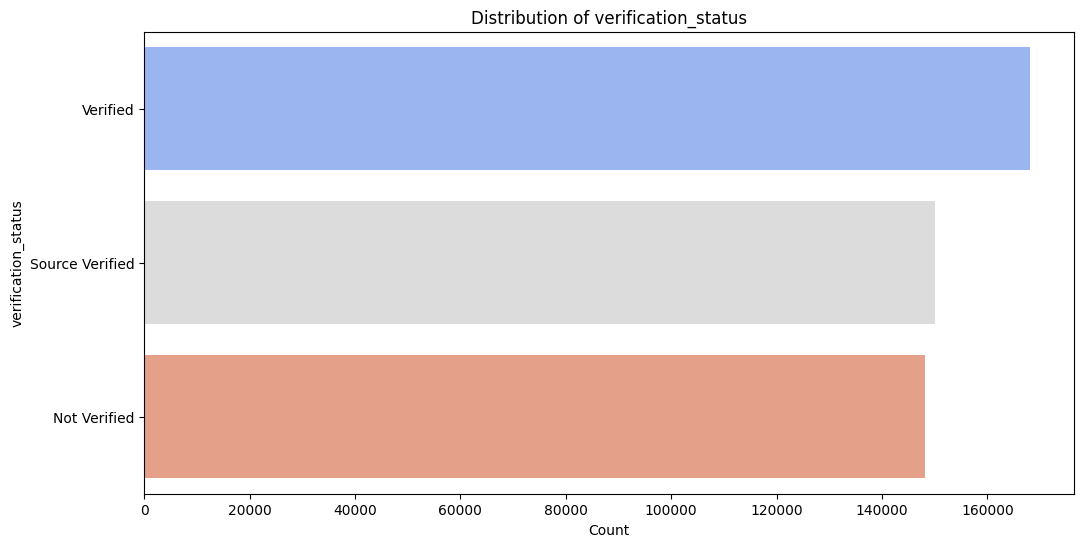

Kolom 'issue_d' memiliki banyak kategori unik (91), hanya menampilkan 10 teratas.


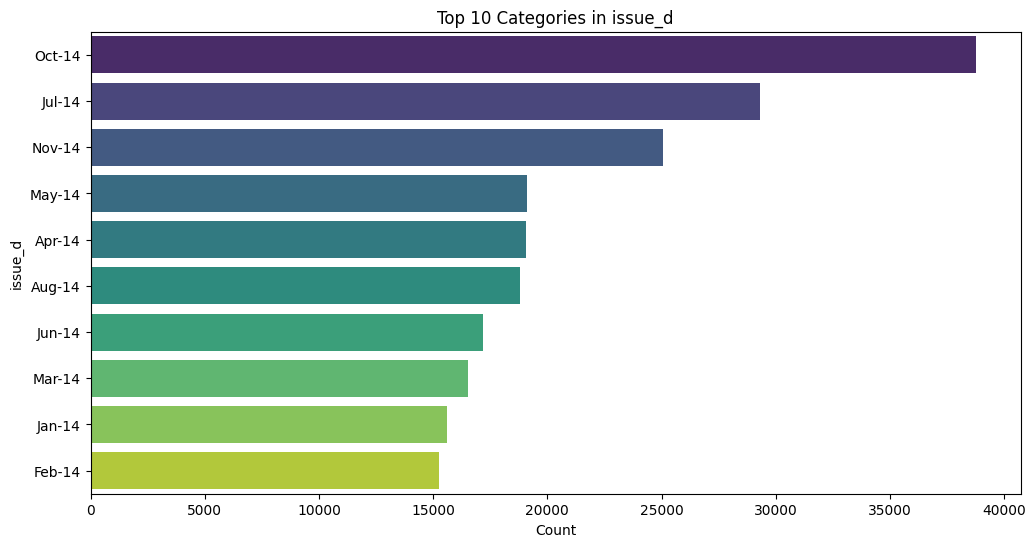

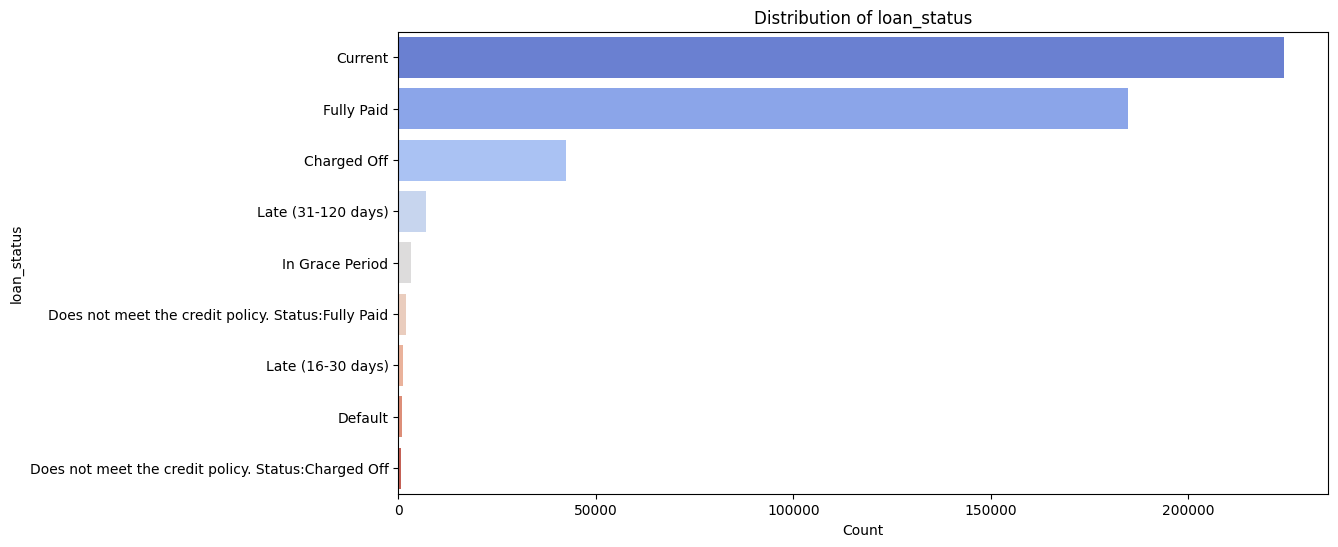

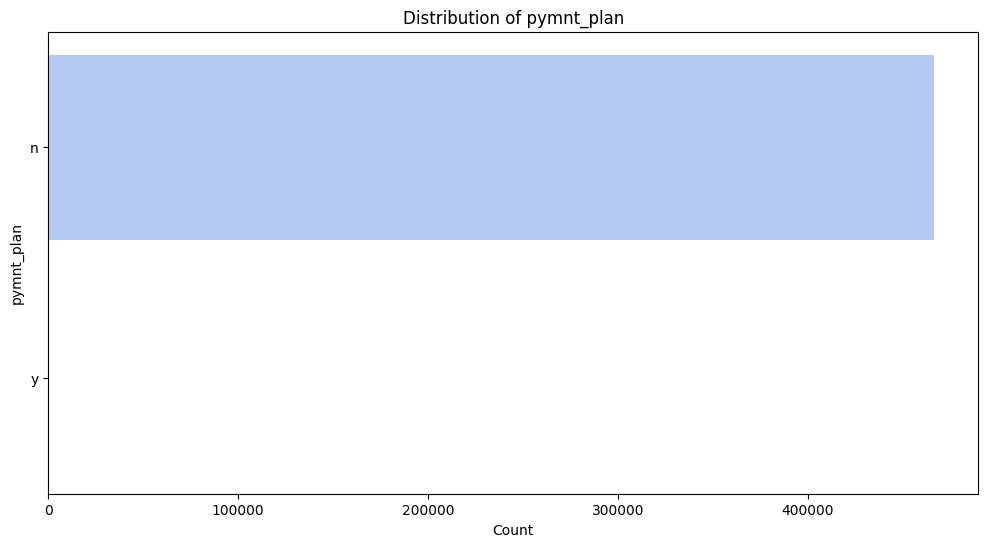

Kolom 'url' memiliki banyak kategori unik (466285), hanya menampilkan 10 teratas.


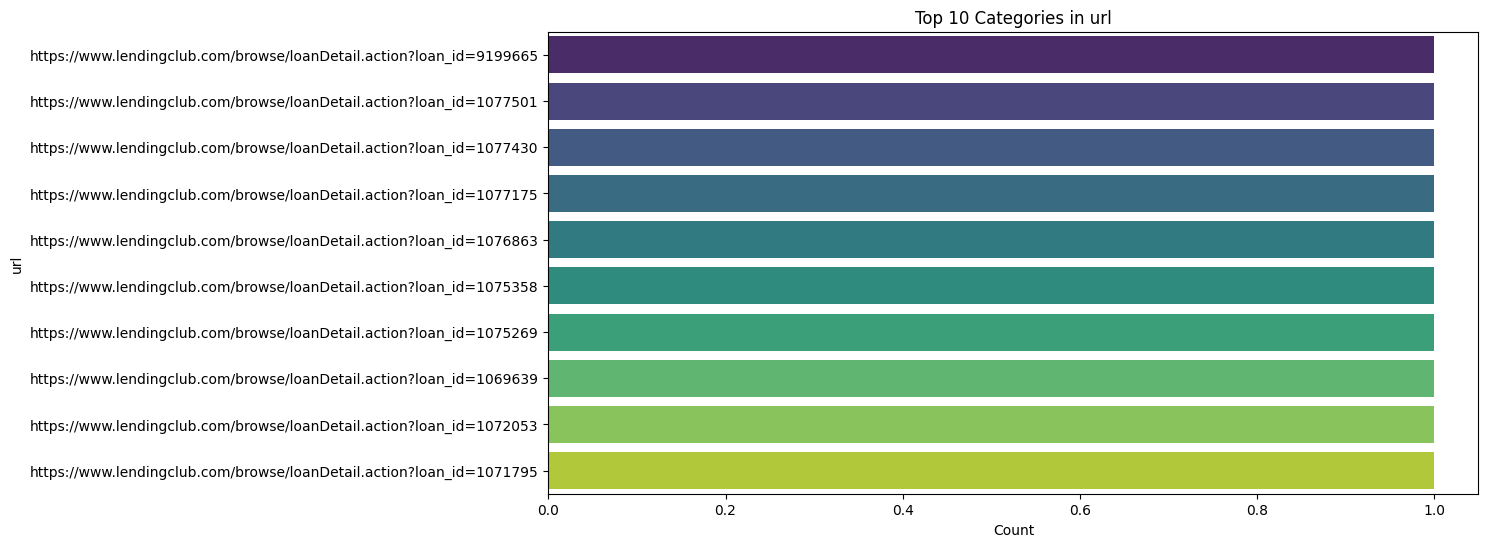

Kolom 'desc' memiliki banyak kategori unik (124435), hanya menampilkan 10 teratas.


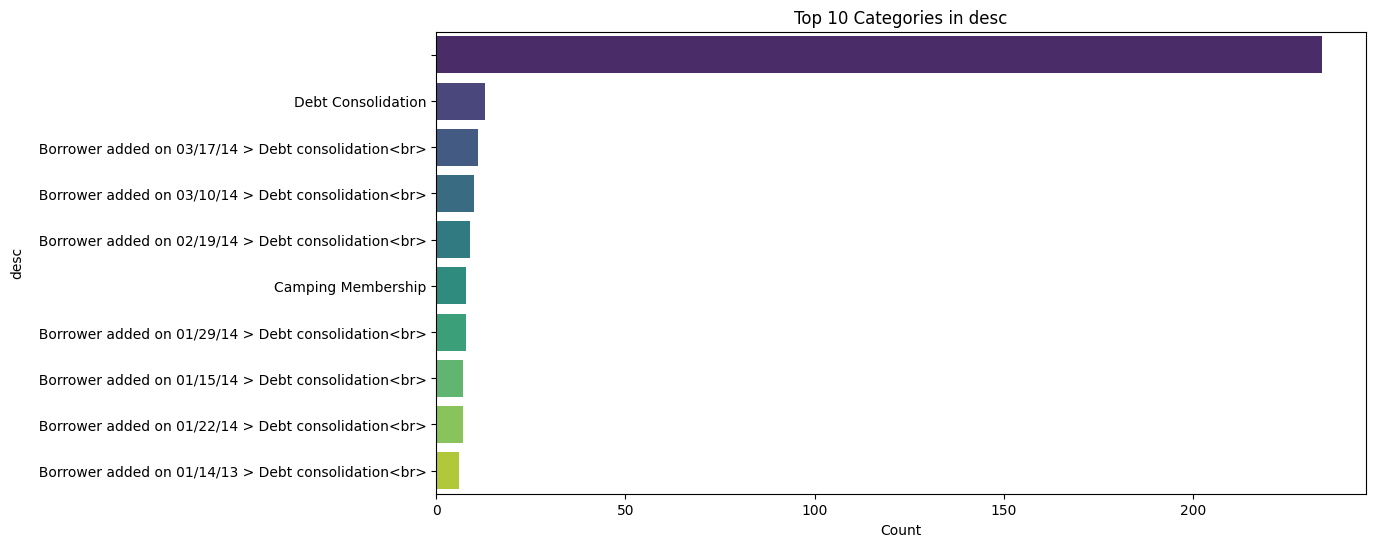

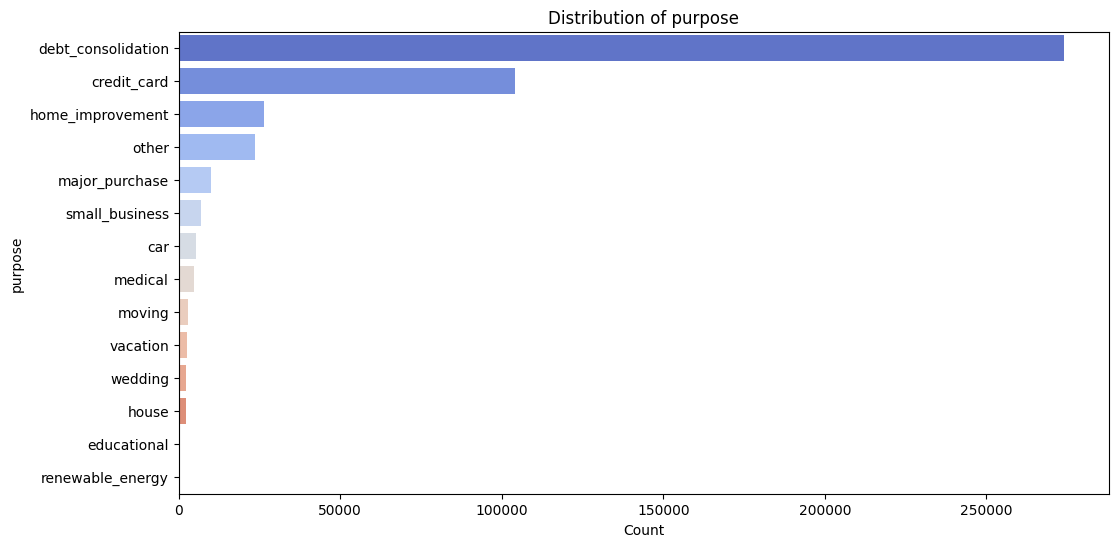

Kolom 'title' memiliki banyak kategori unik (63098), hanya menampilkan 10 teratas.


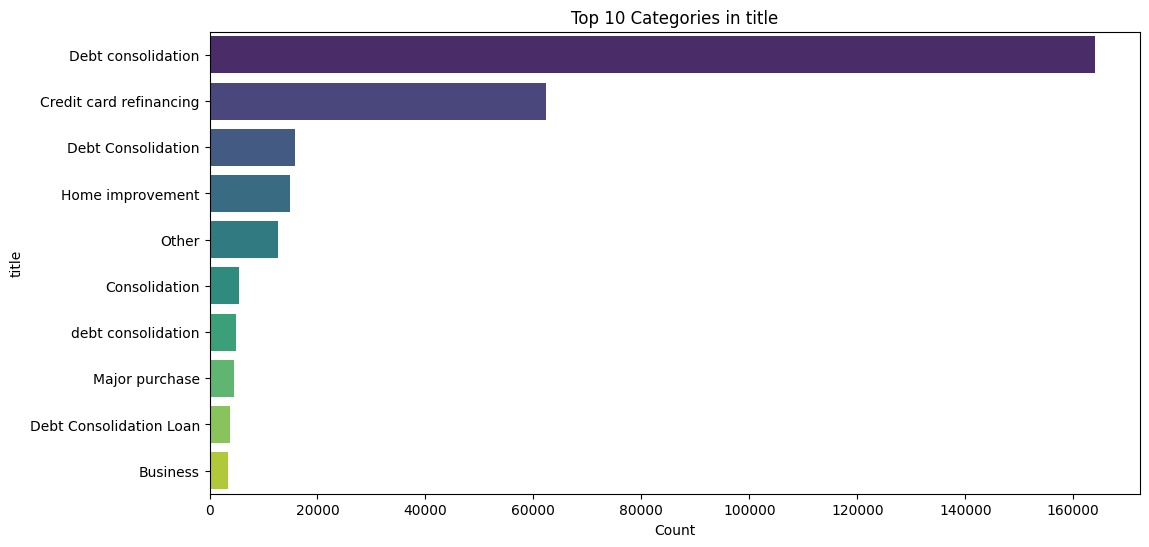

Kolom 'zip_code' memiliki banyak kategori unik (888), hanya menampilkan 10 teratas.


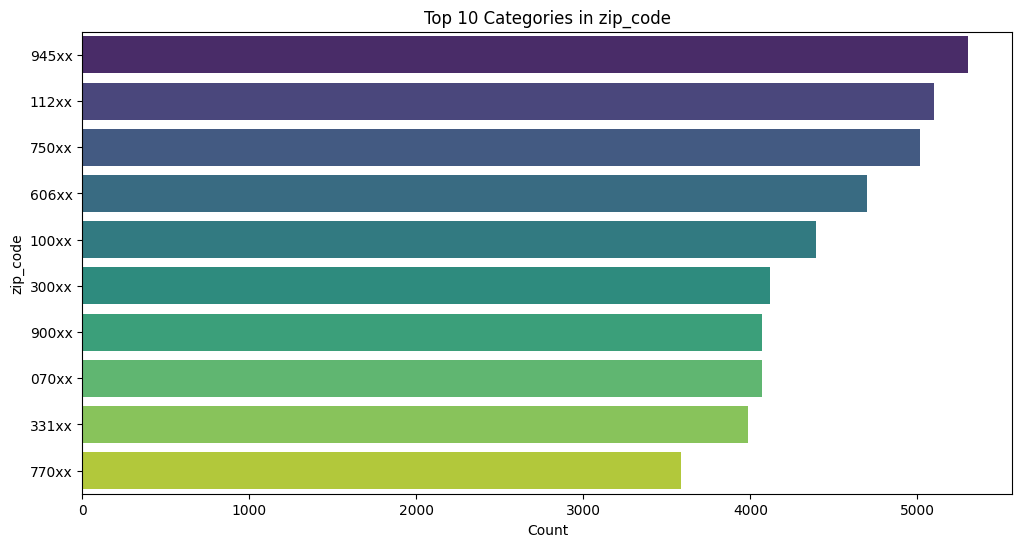

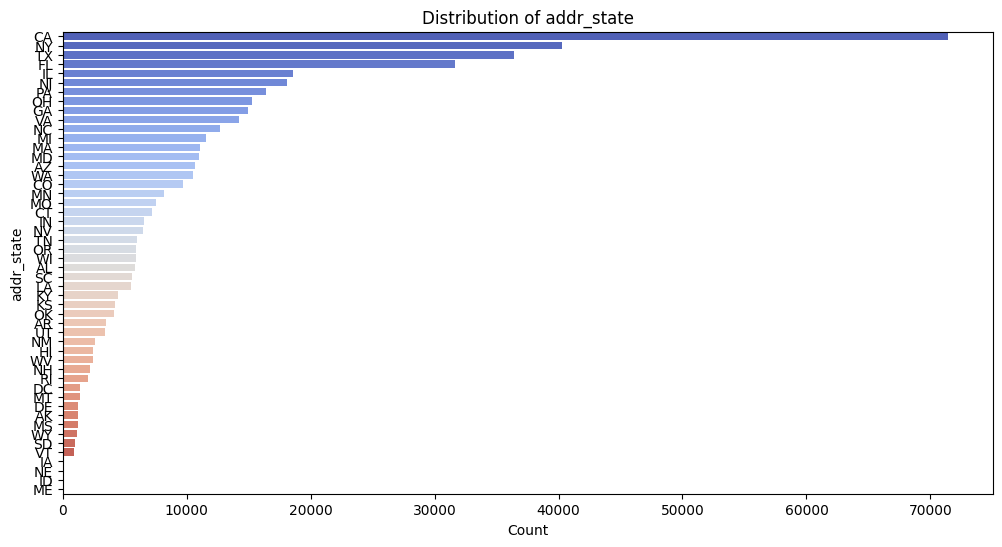

Kolom 'earliest_cr_line' memiliki banyak kategori unik (664), hanya menampilkan 10 teratas.


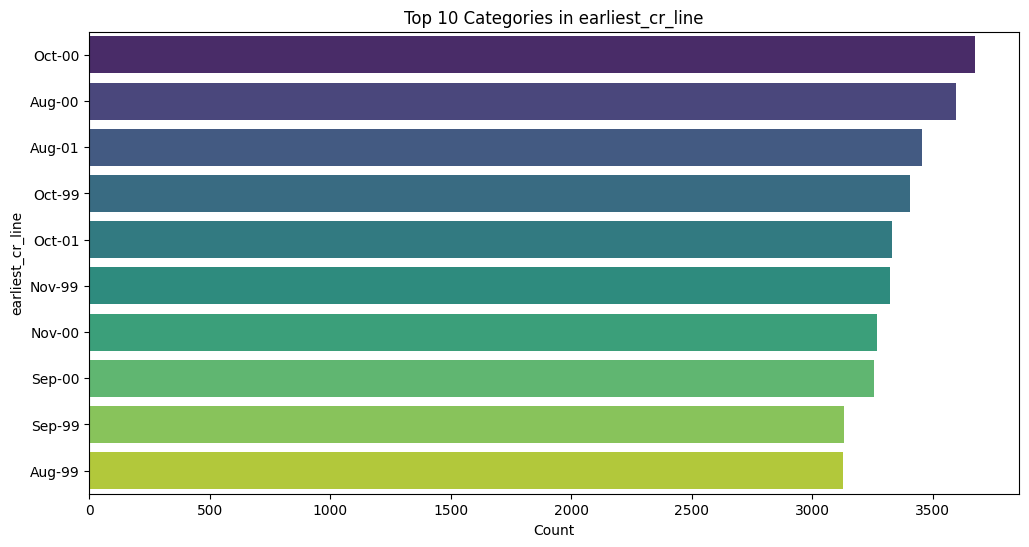

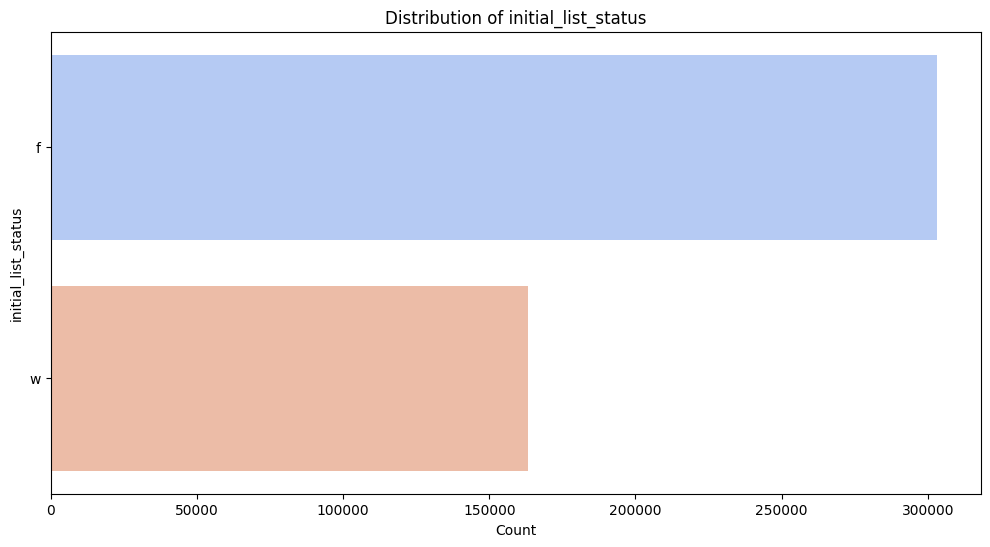

Kolom 'last_pymnt_d' memiliki banyak kategori unik (98), hanya menampilkan 10 teratas.


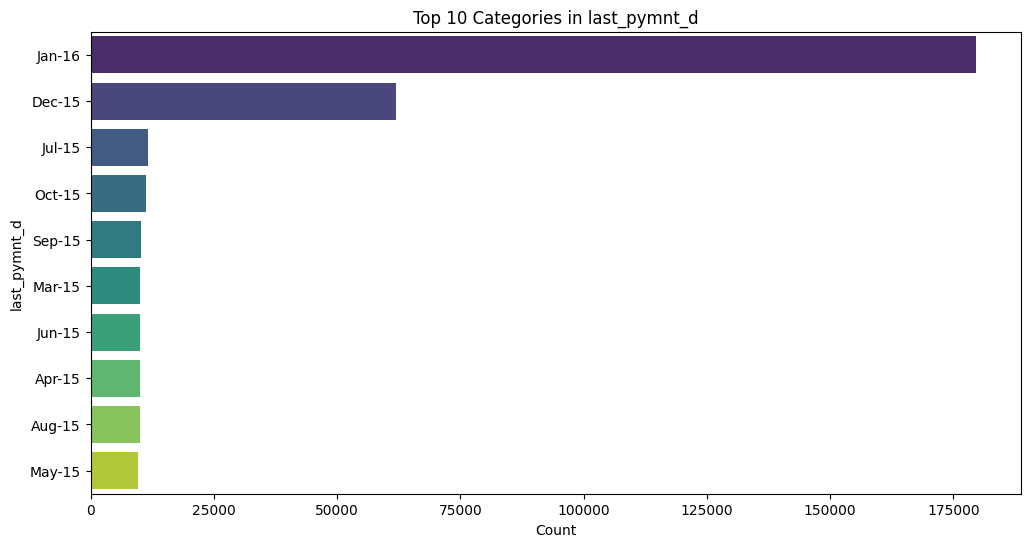

Kolom 'next_pymnt_d' memiliki banyak kategori unik (100), hanya menampilkan 10 teratas.


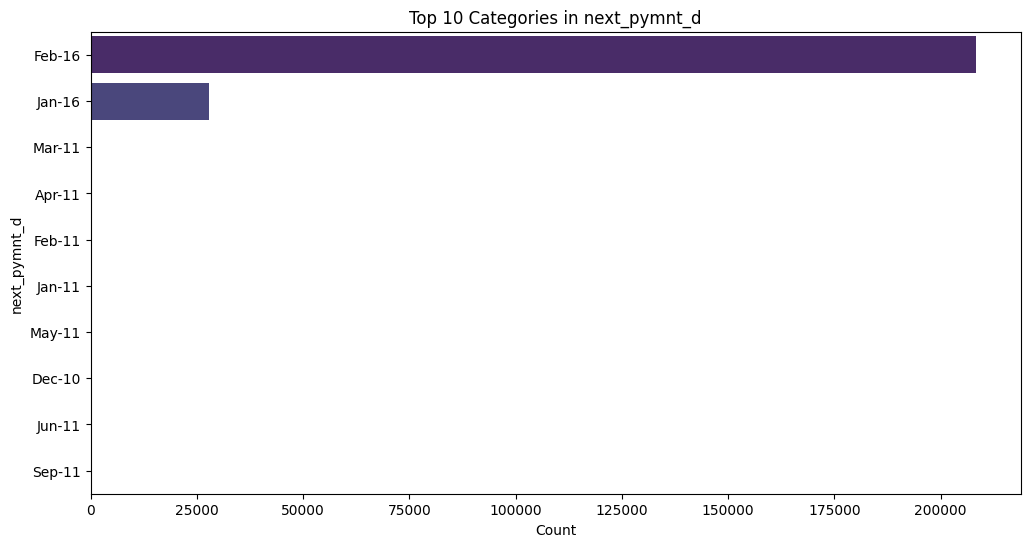

Kolom 'last_credit_pull_d' memiliki banyak kategori unik (103), hanya menampilkan 10 teratas.


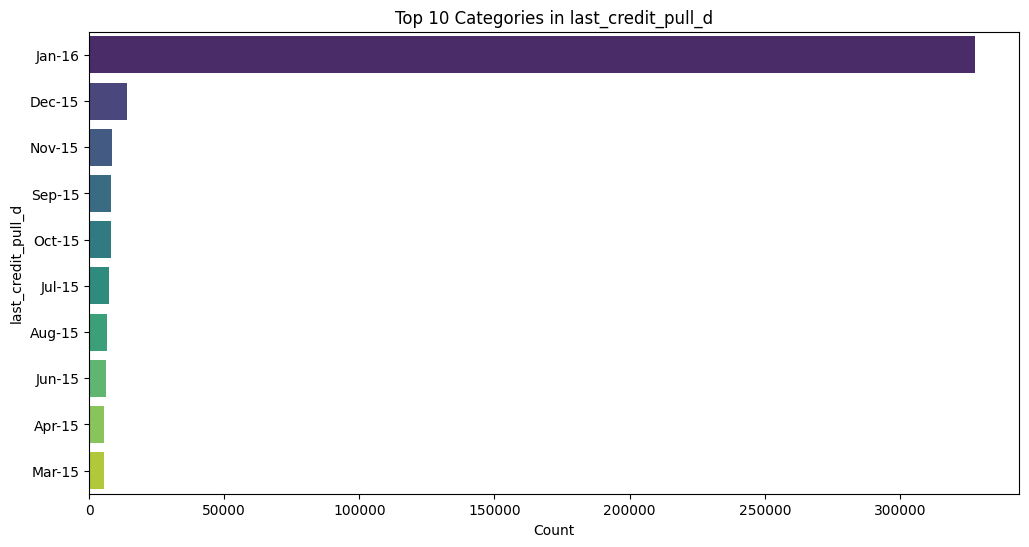

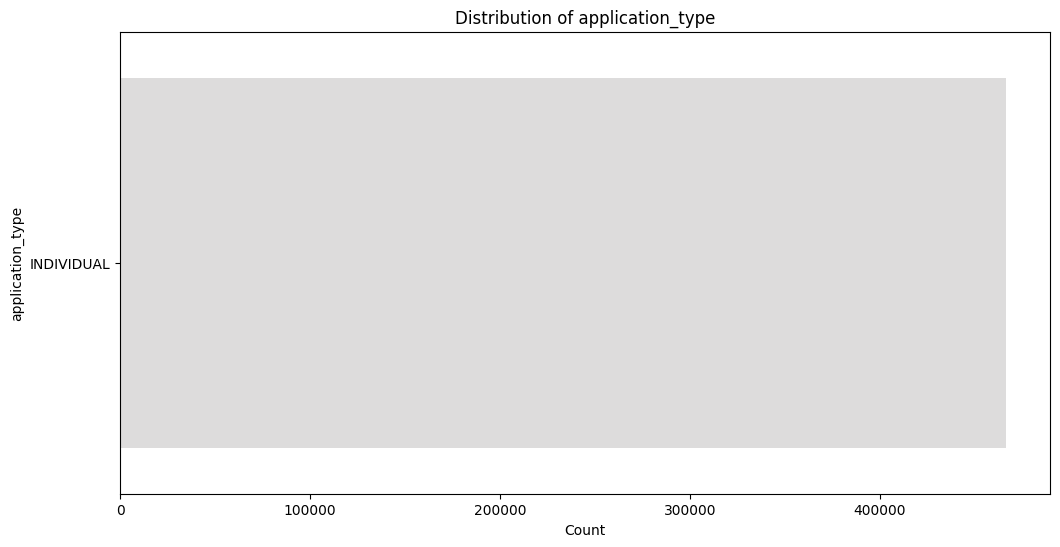

In [ ]:
# Menampilkan distribusi data kategorik dengan kategori terbanyak
def plot_top_categories(df, col, top_n=10):
    plt.figure(figsize=(12, 6))

    # Menghitung frekuensi kategori
    top_categories = df[col].value_counts().nlargest(top_n)

    sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")

    plt.title(f'Top {top_n} Categories in {col}')
    plt.xlabel('Count')
    plt.ylabel(col)
    plt.show()

# Memilih kolom kategorik
cat_cols = df.select_dtypes(include=['object']).columns

# Loop melalui setiap kolom kategorik dan plot distribusi kategori terbanyak
for col in cat_cols:
    if df[col].nunique() > 50:  # Jika kategori sangat banyak, tampilkan 10 teratas
        print(f"Kolom '{col}' memiliki banyak kategori unik ({df[col].nunique()}), hanya menampilkan {10} teratas.")
        plot_top_categories(df, col, top_n=10)
    else:  # Jika kategori sedikit, tampilkan semua
        plt.figure(figsize=(12, 6))
        sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette="coolwarm")
        plt.title(f'Distribution of {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.show()

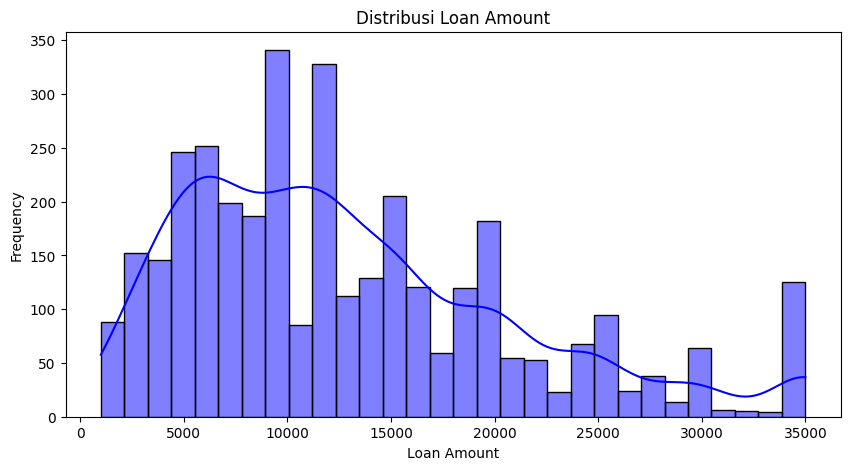

In [ ]:
# Melihat jumlah pengajuan pinjaman berdasarkan jumlah pinjaman
loan_counts = df['loan_amnt'].value_counts()

plt.figure(figsize=(10,5))
sns.histplot(df['loan_amnt'], bins=30, kde=True, color='blue')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.title('Distribusi Loan Amount')
plt.show()

Grafik histogram ini menunjukkan distribusi jumlah pinjaman (Loan Amount) yang diajukan oleh peminjam

- Distribusi Loan Amount menunjukkan pola yang tidak simetris dan cenderung memiliki lebih banyak data pada kisaran pinjaman tertentu.

- Sebagian besar jumlah pinjaman berkisar antara $5.000 hingga $15.000, yang terlihat dari puncak histogram di rentang tersebut.

- Terdapat beberapa nilai pinjaman tinggi hingga $35.000, namun jumlahnya lebih sedikit dibandingkan dengan kisaran yang lebih rendah.

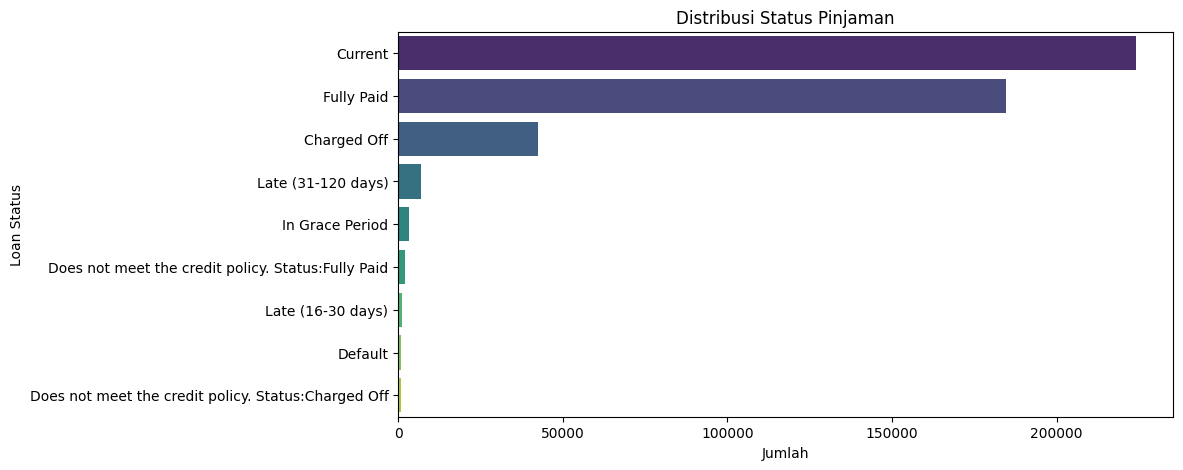

In [ ]:
# Menghitung jumlah setiap kategori dalam loan_status
plt.figure(figsize=(10,5))
sns.countplot(y=df['loan_status'], order=df['loan_status'].value_counts().index, palette="viridis")
plt.xlabel("Jumlah")
plt.ylabel("Loan Status")
plt.title("Distribusi Status Pinjaman")
plt.show()

1. **Status Pinjaman Dominan**: Mayoritas pinjaman dalam status **Current (aktif berjalan)**, diikuti oleh **Fully Paid (lunas)**.  
2. **Non-performing Loans**: **Charged Off (gagal bayar)** cukup signifikan, sedangkan kategori **Late (terlambat 31-120 hari)** lebih kecil.  
3. **Kategori Minor**: **In Grace Period, Late (16-30 hari), dan Default** memiliki jumlah yang sangat kecil.  
4. **Pinjaman Tidak Sesuai Kebijakan Kredit**: Ada kategori khusus untuk pinjaman yang tidak memenuhi kebijakan kredit namun tetap dicatat.

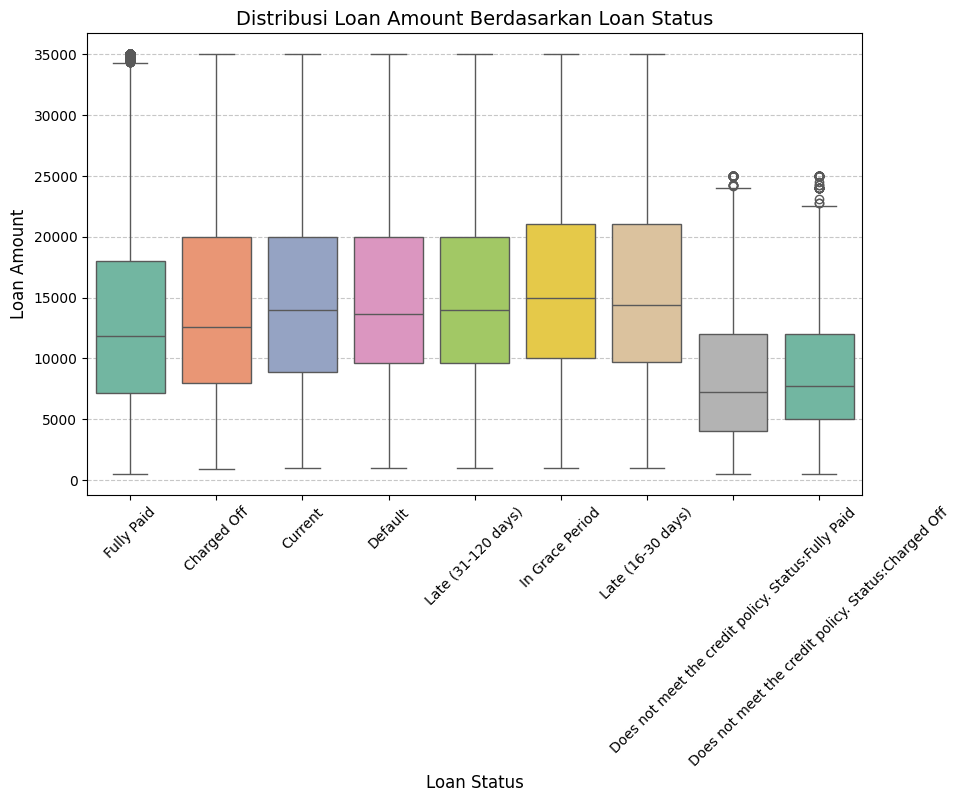

In [ ]:
# Boxplot Loan Amount vs Loan Status (Pola Risiko Kredit)
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["loan_status"], y=df["loan_amnt"], palette="Set2")
plt.title("Distribusi Loan Amount Berdasarkan Loan Status", fontsize=14)
plt.xlabel("Loan Status", fontsize=12)
plt.ylabel("Loan Amount", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()

1. **Sebaran Pinjaman Serupa di Semua Kategori**: Distribusi loan amount relatif merata di semua status pinjaman.  
2. **Rentang Loan Amount Luas**: Semua kategori memiliki pinjaman dari nilai rendah hingga tinggi (~35.000).  
3. **Fully Paid vs Charged Off**: Tidak ada perbedaan mencolok dalam jumlah pinjaman antara pinjaman yang lunas dan yang gagal bayar.  
4. **Pinjaman Bermasalah**: Kategori seperti **Late (31-120 days)** dan **Default** memiliki distribusi yang hampir sama dengan kategori lain.  
5. **Pinjaman Tidak Sesuai Kebijakan Kredit**: Memiliki sebaran yang sedikit lebih rendah dibanding kategori lainnya.

# **Data Preparation**

In [ ]:
df_cleaned = df.copy()

In [ ]:
# Membuat matriks korelasi absolut untuk kolom numerik
cor_matrix = df_cleaned[num_cols].corr().abs()

# Mengambil segitiga atas dari matriks korelasi
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

# Menentukan fitur yang memiliki korelasi lebih dari 0.7 untuk di-drop
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]

# Menampilkan kolom yang akan di-drop
print("Kolom yang di-drop karena korelasi tinggi:", to_drop)

# Menghapus fitur yang memiliki korelasi tinggi
df_cleaned = df_cleaned.drop(columns=to_drop)

Kolom yang di-drop karena korelasi tinggi: ['member_id', 'funded_amnt', 'funded_amnt_inv', 'installment', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'collection_recovery_fee', 'last_pymnt_amnt', 'mths_since_last_major_derog', 'total_rev_hi_lim']


13 kolom yang memiliki korelasi tinggi berhasil dihapus

In [ ]:
# Mengubah 'emp_length' ke numerik
df_cleaned['emp_length'] = df_cleaned['emp_length'].str.extract(r'(\d+)')  # Ambil angka

df_cleaned['emp_length'] = df_cleaned['emp_length'].astype(float)  # Ubah ke tipe float

# Mengubah 'term' ke numerik, tangani nilai non-numerik
df_cleaned['term'] = pd.to_numeric(df_cleaned['term'].str.replace(' months', '', regex=True), errors='coerce')

# Mengisi nilai NaN di 'term' dengan median (atau strategi lain yang sesuai)
df_cleaned['term'] = df_cleaned['term'].fillna(df_cleaned['term'].median())

# Menampilkan hasil
print(df_cleaned[['emp_length', 'term']].head())

   emp_length  term
0        10.0    36
1         1.0    60
2        10.0    36
3        10.0    36
4         1.0    60


- **Kolom `emp_length`**: Diubah ke format numerik untuk merepresentasikan lama bekerja dalam tahun, memungkinkan analisis statistik dan pemodelan yang lebih akurat.  
- **Kolom `term`**: Kata "months" dihapus dan dikonversi ke tipe numerik agar dapat digunakan dalam perhitungan tanpa perlu pemrosesan tambahan.

In [ ]:
# Menetapkan tanggal referensi
reference_date = pd.to_datetime('2016-03-01')

# Fungsi untuk menghitung selisih bulan dari tanggal referensi
def calculate_month_difference(date_series, ref_date):
    """Menghitung selisih bulan antara date_series dan ref_date."""
    return ((ref_date - date_series).dt.days / 30.4375).round()  # 30.4375 adalah rata-rata jumlah hari dalam sebulan

# Daftar kolom yang perlu dikonversi
date_columns = ['earliest_cr_line', 'last_credit_pull_d', 'last_pymnt_d', 'next_pymnt_d', 'issue_d']

# Konversi kolom ke format datetime, dengan perbaikan untuk format '%b-%y'
for col in date_columns:
    df_cleaned[col] = pd.to_datetime(df_cleaned[col], format='%b-%y', errors='coerce')

    # Koreksi tahun yang salah (misalnya, tahun lebih besar dari 2025)
    df_cleaned[col] = df_cleaned[col].apply(lambda x: x - pd.DateOffset(years=100) if pd.notna(x) and x.year > 2025 else x)

    # Hitung selisih bulan
    df_cleaned[col] = calculate_month_difference(df_cleaned[col], reference_date)

# Menampilkan statistik deskriptif untuk memastikan hasilnya benar
print(df_cleaned[date_columns].describe())

       earliest_cr_line  last_credit_pull_d   last_pymnt_d   next_pymnt_d  \
count     466256.000000       466243.000000  465909.000000  239071.000000   
mean         221.491078            6.045588      10.294369       1.738136   
std           86.928944            9.636423      12.809898       6.082298   
min           52.000000            2.000000       2.000000       0.000000   
25%          163.000000            2.000000       2.000000       1.000000   
50%          205.000000            2.000000       3.000000       1.000000   
75%          264.000000            4.000000      14.000000       1.000000   
max          866.000000          106.000000      99.000000      99.000000   

             issue_d  
count  466285.000000  
mean       30.255187  
std        14.340154  
min        15.000000  
25%        20.000000  
50%        26.000000  
75%        36.000000  
max       105.000000  


1. **`earliest_cr_line` (Umur Kredit Pertama)**
   - Rata-rata: **221 bulan** (~18 tahun).  
   - Minimum: **52 bulan** (4 tahun), maksimum **866 bulan** (72 tahun).  

2. **`last_credit_pull_d` (Penarikan Kredit Terakhir)**
   - Rata-rata: **6 bulan**, dengan rentang **2-4 bulan**.  

3. **`last_pymnt_d` (Pembayaran Terakhir)**
   - Rata-rata: **10 bulan**, tetapi ada variasi signifikan hingga 99 bulan.

4. **`next_pymnt_d` (Pembayaran Berikutnya)**
   - Hanya tersedia untuk sebagian data, dengan mayoritas pinjaman memiliki pembayaran berikutnya dalam 1 bulan.

5. **`issue_d` (Bulan Penerbitan Pinjaman)**
   - Rata-rata 30 bulan sejak pinjaman diterbitkan, dengan variasi hingga 105 bulan (~8 tahun).



In [ ]:
# Menghitung persentase nilai yang hilang untuk setiap kolom
check_missing = df_cleaned.isnull().mean() * 100

# Memfilter dan mengurutkan kolom yang memiliki nilai hilang dalam urutan menurun
missing_columns = check_missing[check_missing > 0].sort_values(ascending=False)

# Menampilkan hasil
print(missing_columns)

open_rv_24m                   100.000000
max_bal_bc                    100.000000
total_cu_tl                   100.000000
dti_joint                     100.000000
annual_inc_joint              100.000000
verification_status_joint     100.000000
inq_last_12m                  100.000000
open_rv_12m                   100.000000
total_bal_il                  100.000000
mths_since_rcnt_il            100.000000
open_il_12m                   100.000000
open_il_24m                   100.000000
inq_fi                        100.000000
all_util                      100.000000
il_util                       100.000000
open_il_6m                    100.000000
open_acc_6m                   100.000000
mths_since_last_record         86.566585
desc                           72.981975
mths_since_last_delinq         53.690554
next_pymnt_d                   48.728567
tot_cur_bal                    15.071469
tot_coll_amt                   15.071469
emp_title                       5.916553
emp_length      

1. Kolom dengan 100% missing: Beberapa variabel seperti open_rv_24m, total_cu_tl, dti_joint, annual_inc_joint, dan lainnya tidak memiliki data sama sekali.

2. Kolom dengan missing tinggi (>50%): mths_since_last_record (86.57%), desc (72.98%), mths_since_last_delinq (53.69%), dan next_pymnt_d (48.73%).

3. Kolom dengan missing sedang (5-15%): tot_cur_bal dan tot_coll_amt (~15%), emp_title (5.92%), dan emp_length (4.51%).

4. Kolom dengan missing rendah (<1%): Variabel seperti last_pymnt_d, revol_util, collections_12_mths_ex_med, last_credit_pull_d, delinq_2yrs, dan annual_inc memiliki tingkat missing yang sangat kecil (<1%).

In [ ]:
# Mengisi nilai yang hilang pada fitur tertentu dengan asumsi bahwa pelanggan tidak memiliki pinjaman tambahan / riwayat transaksi terkait
cols_fill_zero = ['tot_coll_amt', 'tot_cur_bal', 'collections_12_mths_ex_med', 'acc_now_delinq']
df_cleaned[cols_fill_zero] = df_cleaned[cols_fill_zero].fillna(0)

In [ ]:
# Drop data yang memiliki missing values di atas 50%
df_cleaned = df_cleaned.drop(missing_columns[missing_columns > 50].index, axis=1)

# Drop kolom yang tidak relevan, but check if they exist first
columns_to_drop = ['id', 'url', 'desc', 'title', 'zip_code', 'policy_code',
                    'addr_state', 'Unnamed: 0', 'sub_grade', 'pymnt_plan',
                    'application_type', 'emp_title']
existing_columns = [col for col in columns_to_drop if col in df_cleaned.columns]
df_cleaned = df_cleaned.drop(columns=existing_columns, axis=1)

In [ ]:
# Mengidentifikasi kolom numerik dan kategorikal
num_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df_cleaned.select_dtypes(include=['object']).columns

# Mengisi nilai yang hilang pada kolom numerik dengan median
imputer_median = SimpleImputer(strategy='median')
df_cleaned[num_cols] = imputer_median.fit_transform(df_cleaned[num_cols])

# Mengisi nilai yang hilang pada kolom kategorikal dengan modus (mode)
imputer_mode = SimpleImputer(strategy='most_frequent')

# Loop melalui setiap kolom kategorikal dan lakukan imputasi secara terpisah
for col in cat_cols:
    # Convert the column to string type before imputation
    df_cleaned[col] = df_cleaned[col].astype(str)
    # Reshape to 1D before assigning back to the column
    df_cleaned[col] = imputer_mode.fit_transform(df_cleaned[col].values.reshape(-1, 1)).ravel()

# Cek kembali missing values
df_cleaned.isnull().sum()

loan_amnt                     0
term                          0
int_rate                      0
grade                         0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
purpose                       0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
total_rec_late_fee            0
recoveries                    0
last_pymnt_d                  0
next_pymnt_d                  0
last_credit_pull_d            0
collections_12_mths_ex_med    0
acc_now_delinq                0
tot_coll_amt                  0
tot_cur_bal                   0
dtype: int64

semua kolom yang memiliki missing values sudah teratasi

In [ ]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   466285 non-null  float64
 1   term                        466285 non-null  float64
 2   int_rate                    466285 non-null  float64
 3   grade                       466285 non-null  object 
 4   emp_length                  466285 non-null  float64
 5   home_ownership              466285 non-null  object 
 6   annual_inc                  466285 non-null  float64
 7   verification_status         466285 non-null  object 
 8   issue_d                     466285 non-null  float64
 9   loan_status                 466285 non-null  object 
 10  purpose                     466285 non-null  object 
 11  dti                         466285 non-null  float64
 12  delinq_2yrs                 466285 non-null  float64
 13  earliest_cr_li

tersisa 30 kolom

In [ ]:
df_cleaned['loan_status'].value_counts()

loan_status
Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: count, dtype: int64

1. Mayoritas pinjaman dalam kondisi “Current” (48.08%), artinya pinjaman masih berjalan dan belum lunas.

2. Pinjaman yang sudah lunas (Fully Paid) cukup besar (39.61%), menunjukkan banyak peminjam berhasil menyelesaikan kewajibannya.

3. Pinjaman yang gagal bayar (Charged Off + Default) mencapai ~9.27%, yang berarti ada risiko gagal bayar yang cukup signifikan.

4. Keterlambatan pembayaran (>30 hari) sekitar 1.48%, dan yang terlambat dalam 16-30 hari hanya 0.26%.

5. Kategori "Does not meet the credit policy" memiliki jumlah kecil, namun menunjukkan ada kasus khusus terkait kebijakan kredit yang perlu dianalisis lebih lanjut.

In [ ]:
# Daftar status pinjaman yang dianggap "baik" (tidak bermasalah)
good_status = ['Current', 'Fully Paid', 'In Grace Period']

# Mengkategorikan status pinjaman: 1 untuk baik, 0 untuk bermasalah
df_cleaned['loan_status'] = np.where(df_cleaned['loan_status'].isin(good_status), 1, 0)

# Menampilkan distribusi persentase setiap kategori pinjaman
loan_status_distribution = df_cleaned['loan_status'].value_counts() / len(df_cleaned) * 100

print(loan_status_distribution)

loan_status
1    88.381784
0    11.618216
Name: count, dtype: float64


1. Mayoritas pinjaman dalam kondisi baik (88.38%), yang mencakup pinjaman yang masih berjalan dengan lancar (Current) dan yang sudah lunas (Fully Paid).

2. Sebanyak 11.62% pinjaman mengalami masalah, termasuk Charged Off, Default, atau keterlambatan pembayaran.

3. Rasio ini cukup baik, namun nilai 11.62% tetap mencerminkan adanya risiko gagal bayar yang perlu dimitigasi.

# **Feature Selection**

In [ ]:
df_cleaned.columns.tolist()

['loan_amnt',
 'term',
 'int_rate',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'total_rec_late_fee',
 'recoveries',
 'last_pymnt_d',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal']

In [ ]:
df_selection = df_cleaned.copy()

In [ ]:
def woe_iv(raw, feature_name):
    """
    Menghitung Weight of Evidence (WOE) dan Information Value (IV) untuk fitur tertentu.

    Parameter:
    raw : DataFrame pandas yang berisi data pinjaman
    feature_name : Nama kolom fitur yang akan dianalisis

    Return:
    - DataFrame dengan kolom: feature_name, num_observation, good_loan_prob, weight_of_evidence, information_value
    """

    # Analisis probabilitas
    feature_stats = raw.groupby(feature_name).agg(
        num_observation=('loan_status', 'count'),
        good_loan_prob=('loan_status', 'mean')
    ).reset_index()

    # Menentukan proporsi fitur
    feature_stats['feat_proportion'] = feature_stats['num_observation'] / feature_stats['num_observation'].sum()

    # Menentukan jumlah pinjaman yang disetujui dan ditolak
    feature_stats['num_loan_approve'] = feature_stats['feat_proportion'] * feature_stats['num_observation']
    feature_stats['num_loan_decline'] = (1 - feature_stats['feat_proportion']) * feature_stats['num_observation']

    # Menghitung proporsi persetujuan dan penolakan pinjaman
    feature_stats['prop_loan_approve'] = feature_stats['num_loan_approve'] / feature_stats['num_loan_approve'].sum()
    feature_stats['prop_loan_decline'] = feature_stats['num_loan_decline'] / feature_stats['num_loan_decline'].sum()

    # Menghindari log(0) dengan mengganti nilai nol dengan nilai kecil
    feature_stats.replace({'prop_loan_decline': {0: 0.0001}, 'prop_loan_approve': {0: 0.0001}}, inplace=True)

    # Menghitung Weight of Evidence (WOE)
    feature_stats['weight_of_evidence'] = np.log(feature_stats['prop_loan_approve'] / feature_stats['prop_loan_decline'])

    # Menghitung Information Value (IV)
    feature_stats['information_value'] = (feature_stats['prop_loan_approve'] - feature_stats['prop_loan_decline']) * feature_stats['weight_of_evidence']
    feature_stats['information_value'] = feature_stats['information_value'].sum()

    # Menghapus kolom tidak perlu
    feature_stats = feature_stats.drop(['feat_proportion', 'num_loan_approve', 'num_loan_decline',
                                        'prop_loan_approve', 'prop_loan_decline'], axis=1)

    return feature_stats.sort_values('weight_of_evidence').reset_index(drop=True)

**Categorical Features**

In [ ]:
df_cleaned.describe(include = 'O')

grade home_ownership verification_status             purpose  \
count   466285         466285              466285              466285   
unique       7              6                   3                  14   
top          B       MORTGAGE            Verified  debt_consolidation   
freq    136929         235875              168055              274195   

       initial_list_status  
count               466285  
unique                   2  
top                      f  
freq                303005

1. Grade B adalah yang paling umum dalam pemberian pinjaman, menunjukkan bahwa mayoritas peminjam memiliki risiko menengah (tidak terlalu tinggi atau terlalu rendah).

2. Mayoritas peminjam memiliki rumah dengan status MORTGAGE, yang berarti mereka memiliki rumah dengan pinjaman hipotek (bukan sepenuhnya milik pribadi atau menyewa).

3. Sebagian besar aplikasi pinjaman diverifikasi, menunjukkan tingkat kepercayaan yang lebih tinggi dalam proses persetujuan pinjaman.

4. Tujuan pinjaman paling umum adalah Debt Consolidation (Konsolidasi Utang), yang berarti banyak peminjam menggunakan pinjaman ini untuk menyatukan utang mereka.

5. Status awal listing f lebih umum, tetapi tanpa informasi lebih lanjut, kita perlu memahami apakah ini berkaitan dengan risiko atau bukan.

In [ ]:
woe_iv(df_selection, 'grade')

grade  num_observation  good_loan_prob  weight_of_evidence  \
0     G             3322        0.679711           -3.660567   
1     F            13229        0.741401           -2.257091   
2     E            35757        0.789775           -1.211753   
3     A            74867        0.959328           -0.377550   
4     D            76888        0.835787           -0.345737   
5     C           125293        0.878493            0.275309   
6     B           136929        0.917643            0.398836   

   information_value  
0           0.292639  
1           0.292639  
2           0.292639  
3           0.292639  
4           0.292639  
5           0.292639  
6           0.292639

In [ ]:
woe_iv(df_selection,'home_ownership')

home_ownership  num_observation  good_loan_prob  weight_of_evidence  \
0            ANY                1        1.000000          -12.759563   
1           NONE               50        0.760000           -8.847435   
2          OTHER              182        0.642857           -7.555168   
3            OWN            41704        0.885359           -2.027518   
4           RENT           188473        0.866501           -0.095002   
5       MORTGAGE           235875        0.897594            0.316429   

   information_value  
0            0.31222  
1            0.31222  
2            0.31222  
3            0.31222  
4            0.31222  
5            0.31222

In [ ]:
woe_iv(df_selection,'verification_status')

verification_status  num_observation  good_loan_prob  weight_of_evidence  \
0        Not Verified           148237        0.895262           -0.075220   
1     Source Verified           149993        0.891342           -0.057908   
2            Verified           168055        0.867008            0.114596   

   information_value  
0           0.007663  
1           0.007663  
2           0.007663

In [ ]:
woe_iv(df_selection,'purpose')

purpose  num_observation  good_loan_prob  weight_of_evidence  \
0     renewable_energy              351        0.840456           -6.796087   
1          educational              422        0.637441           -6.611715   
2                house             2269        0.843543           -4.925653   
3              wedding             2343        0.860009           -4.893401   
4             vacation             2487        0.872135           -4.833445   
5               moving             2994        0.834335           -4.646819   
6              medical             4602        0.856584           -4.213461   
7                  car             5397        0.900130           -4.052385   
8       small_business             7013        0.766862           -3.786951   
9       major_purchase             9828        0.891941           -3.443333   
10               other            23690        0.846264           -2.532676   
11    home_improvement            26537        0.893922           -2.412735   
12         credit_card           104157        0.909070           -0.851172   
13  debt_consolidation           274195        0.880946            0.750802   

    information_value  
0            1.409257  
1            1.409257  
2            1.409257  
3            1.409257  
4            1.409257  
5            1.409257  
6            1.409257  
7            1.409257  
8            1.409257  
9            1.409257  
10           1.409257  
11           1.409257  
12           1.409257  
13           1.409257

In [ ]:
woe_iv(df_selection,'initial_list_status')

initial_list_status  num_observation  good_loan_prob  weight_of_evidence  \
0                   w           163280        0.907741           -0.798355   
1                   f           303005        0.870926            0.438211   

   information_value  
0           0.340013  
1           0.340013

**Numerical Features**

In [ ]:
df_cleaned.describe().T

count           mean            std      min  \
loan_amnt                   466285.0   14317.277577    8286.509164   500.00   
term                        466285.0      42.605334      10.719040    36.00   
int_rate                    466285.0      13.829236       4.357587     5.42   
emp_length                  466285.0       6.071405       3.420843     1.00   
annual_inc                  466285.0   73277.293307   54963.341145  1896.00   
issue_d                     466285.0      30.255187      14.340154    15.00   
loan_status                 466285.0       0.883818       0.320444     0.00   
dti                         466285.0      17.218758       7.851121     0.00   
delinq_2yrs                 466285.0       0.284661       0.797343     0.00   
earliest_cr_line            466285.0     221.490052      86.926338    52.00   
inq_last_6mths              466285.0       0.804695       1.091583     0.00   
open_acc                    466285.0      11.186995       4.987380     0.00   
pub_rec                     466285.0       0.160554       0.510848     0.00   
revol_bal                   466285.0   16230.203487   20676.245152     0.00   
revol_util                  466285.0      56.177985      23.724005     0.00   
total_acc                   466285.0      25.064302      11.599792     1.00   
out_prncp                   466285.0    4410.062342    6355.078769     0.00   
total_rec_late_fee          466285.0       0.650129       5.265730     0.00   
recoveries                  466285.0      85.344211     552.216084     0.00   
last_pymnt_d                466285.0      10.288487      12.806406     2.00   
next_pymnt_d                466285.0       1.378453       4.370769     0.00   
last_credit_pull_d          466285.0       6.045223       9.636066     2.00   
collections_12_mths_ex_med  466285.0       0.009082       0.108632     0.00   
acc_now_delinq              466285.0       0.004002       0.068635     0.00   
tot_coll_amt                466285.0     162.989331   13482.891854     0.00   
tot_cur_bal                 466285.0  117882.255951  148719.648028     0.00   

                                 25%       50%        75%         max  
loan_amnt                    8000.00  12000.00   20000.00    35000.00  
term                           36.00     36.00      60.00       60.00  
int_rate                       10.99     13.66      16.49       26.06  
emp_length                      3.00      6.00      10.00       10.00  
annual_inc                  45000.00  63000.00   88953.00  7500000.00  
issue_d                        20.00     26.00      36.00      105.00  
loan_status                     1.00      1.00       1.00        1.00  
dti                            11.36     16.87      22.78       39.99  
delinq_2yrs                     0.00      0.00       0.00       29.00  
earliest_cr_line              163.00    205.00     264.00      866.00  
inq_last_6mths                  0.00      0.00       1.00       33.00  
open_acc                        8.00     10.00      14.00       84.00  
pub_rec                         0.00      0.00       0.00       63.00  
revol_bal                    6413.00  11764.00   20333.00  2568995.00  
revol_util                     39.20     57.60      74.70      892.30  
total_acc                      17.00     23.00      32.00      156.00  
out_prncp                       0.00    441.47    7341.65    32160.38  
total_rec_late_fee              0.00      0.00       0.00      358.68  
recoveries                      0.00      0.00       0.00    33520.27  
last_pymnt_d                    2.00      3.00      14.00       99.00  
next_pymnt_d                    1.00      1.00       1.00       99.00  
last_credit_pull_d              2.00      2.00       4.00      106.00  
collections_12_mths_ex_med      0.00      0.00       0.00       20.00  
acc_now_delinq                  0.00      0.00       0.00        5.00  
tot_coll_amt                    0.00      0.00       0.00  9152545.00  
tot_cur_bal              

In [ ]:
df_selection['loan_amnt_fs'] = pd.cut(df_selection['loan_amnt'], 5)
woe_iv(df_selection,'loan_amnt_fs')

loan_amnt_fs  num_observation  good_loan_prob  weight_of_evidence  \
0  (28100.0, 35000.0]            34906        0.875867           -1.391294   
1  (21200.0, 28100.0]            52172        0.882504           -0.948559   
2     (465.5, 7400.0]           103603        0.884096           -0.129926   
3  (14300.0, 21200.0]           118918        0.883458            0.051086   
4   (7400.0, 14300.0]           156686        0.886116            0.442000   

   information_value  
0           0.249414  
1           0.249414  
2           0.249414  
3           0.249414  
4           0.249414

In [ ]:
woe_iv(df_selection,'term')

term  num_observation  good_loan_prob  weight_of_evidence  \
0  60.0           128332        0.853458           -1.378129   
1  36.0           337953        0.895346            0.558444   

   information_value  
0            0.72423  
1            0.72423

In [ ]:
df_selection['int_rate_fs'] = pd.cut(df_selection['int_rate'], 5)
woe_iv(df_selection,'int_rate_fs')

int_rate_fs  num_observation  good_loan_prob  weight_of_evidence  \
0   (21.932, 26.06]            23189        0.761870           -1.899708   
1  (17.804, 21.932]            57785        0.809241           -0.905362   
2    (5.399, 9.548]            83978        0.959859           -0.465268   
3  (13.676, 17.804]           147973        0.860704            0.284398   
4   (9.548, 13.676]           153360        0.911020            0.337225   

   information_value  
0           0.284226  
1           0.284226  
2           0.284226  
3           0.284226  
4           0.284226

In [ ]:
df_selection['emp_length_fs'] = pd.cut(df_selection['emp_length'], bins=[0, 2, 5, 7, 10], labels=['0-2', '3-5', '6-7', '8-10'])
woe_iv(df_selection, 'emp_length_fs')

emp_length_fs  num_observation  good_loan_prob  weight_of_evidence  \
0           6-7            73300        0.875334           -0.764795   
1           3-5            95393        0.881176           -0.443489   
2           0-2           107260        0.875583           -0.293720   
3          8-10           190332        0.893050            0.542956   

   information_value  
0           0.263113  
1           0.263113  
2           0.263113  
3           0.263113

In [ ]:
df_selection['annual_inc_fs'] = pd.cut(df_selection['annual_inc'], 5)
woe_iv(df_selection,'annual_inc_fs')

annual_inc_fs  num_observation  good_loan_prob  \
0  (3001137.6, 4500758.4]                1        1.000000   
1  (4500758.4, 6000379.2]                4        1.000000   
2  (6000379.2, 7500000.0]                4        1.000000   
3  (1501516.8, 3001137.6]               10        1.000000   
4  (-5602.104, 1501516.8]           466266        0.883813   

   weight_of_evidence  information_value  
0          -22.467463           10.68265  
1          -21.081162           10.68265  
2          -21.081162           10.68265  
3          -20.164858           10.68265  
4            0.693160           10.68265

In [ ]:
df_selection['issue_d_fs'] = pd.cut(df_selection['issue_d'], bins=5)
woe_iv(df_selection,'issue_d_fs')

issue_d_fs  num_observation  good_loan_prob  weight_of_evidence  \
0  (87.0, 105.0]             2743        0.485235           -5.301683   
1   (69.0, 87.0]             9607        0.790778           -4.033325   
2   (51.0, 69.0]            27918        0.836915           -2.925623   
3   (33.0, 51.0]            98109        0.848954           -1.494320   
4  (14.91, 33.0]           327908        0.904302            0.690913   

   information_value  
0           1.318483  
1           1.318483  
2           1.318483  
3           1.318483  
4           1.318483

In [ ]:
df_selection['dti_fs'] = pd.cut(df_selection['dti'], 5)
woe_iv(df_selection,'dti_fs')

dti_fs  num_observation  good_loan_prob  weight_of_evidence  \
0   (31.992, 39.99]            16407        0.864814           -2.306884   
1    (-0.04, 7.998]            59690        0.901642           -0.914269   
2  (23.994, 31.992]            80361        0.863827           -0.564727   
3   (7.998, 15.996]           154680        0.897110            0.304006   
4  (15.996, 23.994]           155147        0.876072            0.308521   

   information_value  
0           0.293918  
1           0.293918  
2           0.293918  
3           0.293918  
4           0.293918

In [ ]:
df_selection['delinq_2yrs_fs'] = np.where(df_selection['delinq_2yrs'] > 3, '3+',
                                 np.where(df_selection['delinq_2yrs'] == 2, '2',
                                 np.where(df_selection['delinq_2yrs'] == 1, '1', '0')))
woe_iv(df_selection,'delinq_2yrs_fs')

delinq_2yrs_fs  num_observation  good_loan_prob  weight_of_evidence  \
0             3+             5084        0.881786           -5.406375   
1              2            16310        0.880135           -4.216053   
2              1            56224        0.885654           -2.885602   
3              0           388667        0.883733            0.712284   

   information_value  
0           2.038543  
1           2.038543  
2           2.038543  
3           2.038543

In [ ]:
df_selection['earliest_cr_line_fs'] = pd.cut(df_selection['earliest_cr_line'], 5)
woe_iv(df_selection,'earliest_cr_line_fs')

earliest_cr_line_fs  num_observation  good_loan_prob  weight_of_evidence  \
0      (703.2, 866.0]               35        0.857143           -9.334094   
1      (540.4, 703.2]             2003        0.874189           -5.282811   
2      (377.6, 540.4]            25427        0.905612           -2.689876   
3      (214.8, 377.6]           181092        0.892949           -0.291126   
4     (51.186, 214.8]           257728        0.875330            0.374728   

   information_value  
0           0.392162  
1           0.392162  
2           0.392162  
3           0.392162  
4           0.392162

In [ ]:
df_selection['inq_last_6mths_fs'] = np.where(df_selection['inq_last_6mths'] == 0,0,
                                    np.where((df_selection['inq_last_6mths'] > 0)&(df_selection['inq_last_6mths'] <=3),1,
                                    np.where((df_selection['inq_last_6mths']>3)&(df_selection['inq_last_6mths']<=6),2,
                                    np.where((df_selection['inq_last_6mths']>6)&(df_selection['inq_last_6mths']<=9),3,4))))
woe_iv(df_selection,'inq_last_6mths_fs')

inq_last_6mths_fs  num_observation  good_loan_prob  weight_of_evidence  \
0                  4               95        0.000000           -8.409390   
1                  3              367        0.147139           -7.057322   
2                  2            11197        0.737162           -3.615764   
3                  1           213099        0.869033           -0.083286   
4                  0           241527        0.905129            0.161038   

   information_value  
0           0.188408  
1           0.188408  
2           0.188408  
3           0.188408  
4           0.188408

In [ ]:
df_selection['open_acc_fs'] = pd.cut(df_selection['open_acc'], 5)
woe_iv(df_selection,'open_acc_fs')

open_acc_fs  num_observation  good_loan_prob  weight_of_evidence  \
0    (67.2, 84.0]                4        0.500000          -12.858748   
1    (50.4, 67.2]               22        1.000000          -11.153962   
2    (33.6, 50.4]              898        0.886414           -7.442954   
3    (16.8, 33.6]            61622        0.886907           -3.074535   
4  (-0.084, 16.8]           403739        0.883338            0.672367   

   information_value  
0           1.830395  
1           1.830395  
2           1.830395  
3           1.830395  
4           1.830395

In [ ]:
df_selection['pub_rec_fs'] = pd.cut(df_selection['pub_rec'], 5)
woe_iv(df_selection,'pub_rec_fs')

pub_rec_fs  num_observation  good_loan_prob  weight_of_evidence  \
0    (25.2, 37.8]                1        1.000000          -22.703865   
1    (37.8, 50.4]                2        1.000000          -22.010715   
2    (50.4, 63.0]                2        1.000000          -22.010715   
3    (12.6, 25.2]               10        1.000000          -20.401260   
4  (-0.063, 12.6]           466270        0.883814            0.693155   

   information_value  
0          10.838649  
1          10.838649  
2          10.838649  
3          10.838649  
4          10.838649

In [ ]:
df_selection['revol_bal_fs'] = np.where((df_selection['revol_bal']>=0)&(df_selection['revol_bal']<=5000),0,
                               np.where((df_selection['revol_bal']>5000)&(df_selection['revol_bal']<=10000),1,
                               np.where((df_selection['revol_bal']>10000)&(df_selection['revol_bal']<=15000),2,3)))
woe_iv(df_selection,'revol_bal_fs')

revol_bal_fs  num_observation  good_loan_prob  weight_of_evidence  \
0             0            82590        0.875239           -0.576520   
1             2            88805        0.882011           -0.487635   
2             1           115537        0.880480           -0.151038   
3             3           179353        0.890813            0.489550   

   information_value  
0           0.197731  
1           0.197731  
2           0.197731  
3           0.197731

In [ ]:
df_selection['revol_util_fs'] = np.where((df_selection['revol_util']>=0)&(df_selection['revol_util']<=20),0,
                                np.where((df_selection['revol_util']>20)&(df_selection['revol_util']<=40),1,
                                np.where((df_selection['revol_util']>40)&(df_selection['revol_util']<=60),2,
                                np.where((df_selection['revol_util']>60)&(df_selection['revol_util']<=80),3,4))))
woe_iv(df_selection,'revol_util_fs')

revol_util_fs  num_observation  good_loan_prob  weight_of_evidence  \
0              0            37402        0.907438           -1.220141   
1              1            83492        0.901679           -0.303424   
2              4            84062        0.859449           -0.295130   
3              2           129737        0.889114            0.266088   
4              3           131592        0.876117            0.285812   

   information_value  
0           0.157668  
1           0.157668  
2           0.157668  
3           0.157668  
4           0.157668

In [ ]:
df_selection['total_acc_fs'] = pd.cut(df_selection['total_acc'], 5)
woe_iv(df_selection,'total_acc_fs')

total_acc_fs  num_observation  good_loan_prob  weight_of_evidence  \
0  (125.0, 156.0]                2        1.000000          -12.936344   
1   (94.0, 125.0]               28        0.964286          -10.297231   
2    (63.0, 94.0]             1221        0.904177           -6.519448   
3    (32.0, 63.0]           107819        0.891911           -1.778323   
4   (0.845, 32.0]           357215        0.881298            0.609405   

   information_value  
0            1.03453  
1            1.03453  
2            1.03453  
3            1.03453  
4            1.03453

In [ ]:
df_selection['out_prncp_fs'] = np.where((df_selection['out_prncp']>=0)&(df_selection['out_prncp']<=1000),0,
                               np.where((df_selection['out_prncp']>1000)&(df_selection['out_prncp']<=10000),1,
                               np.where((df_selection['out_prncp']>10000)&(df_selection['out_prncp']<=17000),2,3)))
woe_iv(df_selection,'out_prncp_fs')

out_prncp_fs  num_observation  good_loan_prob  weight_of_evidence  \
0             3            28933        0.948225           -2.216759   
1             2            53928        0.956887           -1.535243   
2             1           142293        0.965585           -0.323834   
3             0           241131        0.811497            0.567552   

   information_value  
0           0.587279  
1           0.587279  
2           0.587279  
3           0.587279

In [ ]:
df_selection['total_rec_late_fee_fs'] = np.where(df_selection['total_rec_late_fee']==0,0,1)

# show
woe_iv(df_selection,'total_rec_late_fee_fs')

total_rec_late_fee_fs  num_observation  good_loan_prob  weight_of_evidence  \
0                      1            10678        0.507024           -6.814292   
1                      0           455607        0.892649            0.692598   

   information_value  
0           3.749324  
1           3.749324

In [ ]:
df_selection['recoveries_fs'] = pd.cut(df_selection['recoveries'], 5)
woe_iv(df_selection,'recoveries_fs')

recoveries_fs  num_observation  good_loan_prob  \
0   (26816.216, 33520.27]                5        0.000000   
1  (20112.162, 26816.216]               13        0.000000   
2  (13408.108, 20112.162]               45        0.000000   
3   (6704.054, 13408.108]              315        0.000000   
4      (-33.52, 6704.054]           465907        0.884535   

   weight_of_evidence  information_value  
0          -17.866686           7.407134  
1          -16.911158           7.407134  
2          -15.669376           7.407134  
3          -13.722887           7.407134  
4            0.693264           7.407134

In [ ]:
df_selection['last_pymnt_d_fs'] = np.where(df_selection['last_pymnt_d']==2,0,
                                  np.where((df_selection['last_pymnt_d']>2)&(df_selection['last_pymnt_d']<=4),1,
                                  np.where((df_selection['last_pymnt_d']>4)&(df_selection['last_pymnt_d']<=6),2,
                                  np.where((df_selection['last_pymnt_d']>6)&(df_selection['last_pymnt_d']<=12),3,4))))

woe_iv(df_selection,'last_pymnt_d_fs')

last_pymnt_d_fs  num_observation  good_loan_prob  weight_of_evidence  \
0                2            21452        0.793259           -2.045979   
1                3            61476        0.790487           -0.898867   
2                1            71693        0.940454           -0.719558   
3                4           132044        0.759845            0.057175   
4                0           179620        0.995106            0.518431   

   information_value  
0           0.372559  
1           0.372559  
2           0.372559  
3           0.372559  
4           0.372559

In [ ]:
df_selection['next_pymnt_d_fs'] = np.select(
    [
        df_selection['next_pymnt_d'] == 0,
        (df_selection['next_pymnt_d'] > 0) & (df_selection['next_pymnt_d'] <= 1),
        (df_selection['next_pymnt_d'] > 1) & (df_selection['next_pymnt_d'] <= 3),
        (df_selection['next_pymnt_d'] > 3) & (df_selection['next_pymnt_d'] <= 6)
    ],
    [0, 1, 2, 3],
    default=4  # Kategori default jika tidak memenuhi kondisi di atas
)

# Menampilkan hasil WOE & IV
woe_iv(df_selection, 'next_pymnt_d_fs')

next_pymnt_d_fs  num_observation  good_loan_prob  weight_of_evidence  \
0                0               17        1.000000          -12.177741   
1                3               32        0.000000          -11.545186   
2                4             2705        0.000000           -7.102316   
3                2            27924        0.956489           -4.711995   
4                1           435607        0.884708            0.694756   

   information_value  
0           2.813945  
1           2.813945  
2           2.813945  
3           2.813945  
4           2.813945

In [ ]:
df_selection['last_credit_pull_d_fs'] = np.select(
    [
        df_selection['last_credit_pull_d'] == 2,
        (df_selection['last_credit_pull_d'] > 2) & (df_selection['last_credit_pull_d'] <= 4),
        (df_selection['last_credit_pull_d'] > 4) & (df_selection['last_credit_pull_d'] <= 6),
        (df_selection['last_credit_pull_d'] > 6) & (df_selection['last_credit_pull_d'] <= 12)
    ],
    [0, 1, 2, 3],
    default=4  # Kategori default jika tidak memenuhi kondisi di atas
)

# Menampilkan hasil WOE & IV
woe_iv(df_selection, 'last_credit_pull_d_fs')

last_credit_pull_d_fs  num_observation  good_loan_prob  weight_of_evidence  \
0                      2            16008        0.927161           -3.425803   
1                      1            22376        0.852431           -3.076659   
2                      3            36669        0.829665           -2.549988   
3                      4            63491        0.749980           -1.936555   
4                      0           327741        0.915830            0.772007   

   information_value  
0           1.668029  
1           1.668029  
2           1.668029  
3           1.668029  
4           1.668029

In [ ]:
df_selection['collections_12_mths_ex_med_fs'] = pd.cut(df_selection['collections_12_mths_ex_med'], 5)
woe_iv(df_selection,'collections_12_mths_ex_med_fs')

collections_12_mths_ex_med_fs  num_observation  good_loan_prob  \
0                  (12.0, 16.0]                1        1.000000   
1                  (16.0, 20.0]                1        1.000000   
2                    (4.0, 8.0]                2        1.000000   
3                   (8.0, 12.0]                0             NaN   
4                  (-0.02, 4.0]           466281        0.883817   

   weight_of_evidence  information_value  
0           -24.02565          12.186145  
1           -24.02565          12.186145  
2           -23.33250          12.186145  
3             0.00000          12.186145  
4             0.69315          12.186145

In [ ]:
df_selection['acc_now_delinq_fs'] = pd.cut(df_selection['acc_now_delinq'], 5)
woe_iv(df_selection,'acc_now_delinq_fs')

acc_now_delinq_fs  num_observation  good_loan_prob  weight_of_evidence  \
0        (4.0, 5.0]                2        0.500000          -20.027192   
1        (3.0, 4.0]                4        1.000000          -19.334041   
2        (2.0, 3.0]               11        0.818182          -18.322425   
3        (1.0, 2.0]               92        0.902174          -16.198358   
4     (-0.005, 1.0]           466176        0.883816            0.693179   

   information_value  
0           8.645917  
1           8.645917  
2           8.645917  
3           8.645917  
4           8.645917

In [ ]:
df_selection['tot_coll_amt_fs'] = np.select(
    [
        df_selection['tot_coll_amt'] == 0,
        (df_selection['tot_coll_amt'] > 0) & (df_selection['tot_coll_amt'] <= 1000),
        (df_selection['tot_coll_amt'] > 1000) & (df_selection['tot_coll_amt'] <= 10000),
        (df_selection['tot_coll_amt'] > 10000) & (df_selection['tot_coll_amt'] <= 100000),
    ],
    [0, 1, 2, 3],
    default=4  # Untuk nilai lebih besar dari 100000
)

# Menampilkan hasil WOE & IV
woe_iv(df_selection, 'tot_coll_amt_fs')

tot_coll_amt_fs  num_observation  good_loan_prob  weight_of_evidence  \
0                4                7        1.000000          -12.525975   
1                3             1299        0.927637           -7.299760   
2                2            10092        0.902992           -5.230521   
3                1            38352        0.893930           -3.831508   
4                0           416535        0.882284            0.705612   

   information_value  
0           2.477405  
1           2.477405  
2           2.477405  
3           2.477405  
4           2.477405

In [ ]:
df_selection['tot_cur_bal_fs'] = np.select(
    [
        df_selection['tot_cur_bal'] == 0,
        (df_selection['tot_cur_bal'] > 0) & (df_selection['tot_cur_bal'] <= 50000),
        (df_selection['tot_cur_bal'] > 50000) & (df_selection['tot_cur_bal'] <= 150000),
        (df_selection['tot_cur_bal'] > 150000) & (df_selection['tot_cur_bal'] <= 500000),
    ],
    [0, 1, 2, 3],
    default=4  # Untuk nilai lebih besar dari 500000
)

# Menampilkan hasil WOE & IV
woe_iv(df_selection, 'tot_cur_bal_fs')

tot_cur_bal_fs  num_observation  good_loan_prob  weight_of_evidence  \
0               4            10594        0.941476           -2.720848   
1               0            70354        0.815945           -0.687021   
2               2            92820        0.889442           -0.351483   
3               3           134204        0.912439            0.134661   
4               1           158313        0.882562            0.375244   

   information_value  
0           0.215267  
1           0.215267  
2           0.215267  
3           0.215267  
4           0.215267

Seleksi Fitur Berdasarkan Information Value (IV)

Dalam proses pemodelan, seleksi fitur sangat penting untuk memastikan bahwa hanya variabel yang relevan dan informatif yang digunakan dalam prediksi.
IV < 0.02 → Tidak Berguna → Fitur ini tidak memberikan informasi yang cukup dan perlu dihapus.

0.02 – 0.1 → Lemah → Bisa dipertimbangkan jika tidak terlalu banyak fitur yang tersedia.

0.1 – 0.3 → Sedang → Cukup penting dalam prediksi.

0.3 – 0.5 → Kuat → Sangat relevan untuk model.

IV > 0.5 → Mencurigakan → Bisa mengindikasikan kebocoran data atau overfitting.

In [ ]:
# Drop kolom values <0,02 dan > 0.5
drop_list = ['verification_status', 'purpose', 'term', 'annual_inc', 'issue_d', 'delinq_2yrs'
            'open_acc', 'pub_rec',  'total_acc', 'out_prncp', 'total_rec_late_fee', 'recoveries',
            'next_pymnt_d', 'last_credit_pull_d',  'collections_12_mths_ex_med',
             'acc_now_delinq', 'tot_coll_amt']

print(len(drop_list))

16


In [ ]:
df_encoded = df_cleaned.copy()

In [ ]:
df_encoded.drop(['verification_status', 'purpose', 'term', 'annual_inc', 'issue_d', 'delinq_2yrs',
               'open_acc', 'pub_rec', 'total_acc', 'out_prncp', 'total_rec_late_fee', 'recoveries',
                'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
               'acc_now_delinq', 'tot_coll_amt'],  axis = 1, inplace=True)

In [ ]:
nums = df_encoded.select_dtypes(include=np.number).columns
cats = df_encoded.select_dtypes(exclude=np.number).columns

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            466285 non-null  float64
 1   int_rate             466285 non-null  float64
 2   grade                466285 non-null  object 
 3   emp_length           466285 non-null  float64
 4   home_ownership       466285 non-null  object 
 5   loan_status          466285 non-null  int64  
 6   dti                  466285 non-null  float64
 7   earliest_cr_line     466285 non-null  float64
 8   inq_last_6mths       466285 non-null  float64
 9   revol_bal            466285 non-null  float64
 10  revol_util           466285 non-null  float64
 11  initial_list_status  466285 non-null  object 
 12  last_pymnt_d         466285 non-null  float64
 13  tot_cur_bal          466285 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 49.8+ MB


In [ ]:
# Memastikan semua nilai dalam one-hot encoding adalah 0 atau 1
print(df_encoded.dtypes)
print(df_encoded.head())

loan_amnt              float64
int_rate               float64
grade                   object
emp_length             float64
home_ownership          object
loan_status              int64
dti                    float64
earliest_cr_line       float64
inq_last_6mths         float64
revol_bal              float64
revol_util             float64
initial_list_status     object
last_pymnt_d           float64
tot_cur_bal            float64
dtype: object
   loan_amnt  int_rate grade  emp_length home_ownership  loan_status    dti  \
0     5000.0     10.65     B        10.0           RENT            1  27.65   
1     2500.0     15.27     C         1.0           RENT            0   1.00   
2     2400.0     15.96     C        10.0           RENT            1   8.72   
3    10000.0     13.49     C        10.0           RENT            1  20.00   
4     3000.0     12.69     B         1.0           RENT            1  17.94   

   earliest_cr_line  inq_last_6mths  revol_bal  revol_util  \
0             3

Dataset saat ini memiliki 14 kolom dilaur loan status setelah proses seleksi fitur, terdiri dari 10 fitur numerik dan 3 fitur kategorikal:

1. Numerik (float64 atau int64):

- loan_amnt, int_rate, emp_length, loan_status, dti, earliest_cr_line, inq_last_6mths, revol_bal, revol_util, tot_cur_bal

2. Kategorikal (object):

- grade, home_ownership, initial_list_status

# **Feature Engineering**

In [ ]:
# Lakukan One-Hot Encoding pada kategori
for cat in ['grade', 'home_ownership', 'initial_list_status']:
    onehot = pd.get_dummies(df_encoded[cat], prefix=cat, dtype=int)  # Pastikan hasilnya integer
    df_encoded = df_encoded.join(onehot)  # Gabungkan dengan dataset utama

# Hapus kolom asli setelah encoding
df_encoded = df_encoded.drop(columns=['grade', 'home_ownership', 'initial_list_status'])

# Cek hasilnya
print(df_encoded.head())
print(df_encoded.dtypes)  # Pastikan hasil encoding berupa integer (0/1)

   loan_amnt  int_rate  emp_length  loan_status    dti  earliest_cr_line  \
0     5000.0     10.65        10.0            1  27.65             374.0   
1     2500.0     15.27         1.0            0   1.00             203.0   
2     2400.0     15.96        10.0            1   8.72             172.0   
3    10000.0     13.49        10.0            1  20.00             241.0   
4     3000.0     12.69         1.0            1  17.94             242.0   

   inq_last_6mths  revol_bal  revol_util  last_pymnt_d  ...  grade_F  grade_G  \
0             1.0    13648.0        83.7          14.0  ...        0        0   
1             5.0     1687.0         9.4          35.0  ...        0        0   
2             2.0     2956.0        98.5          21.0  ...        0        0   
3             1.0     5598.0        21.0          14.0  ...        0        0   
4             0.0    27783.0        53.9           2.0  ...        0        0   

   home_ownership_ANY  home_ownership_MORTGAGE  home_own

15 fitur kategorikal hasil One-Hot Encoding (int64):

grade_A sampai grade_G (7 kategori)

home_ownership_ANY, home_ownership_MORTGAGE, home_ownership_NONE, home_ownership_OTHER, home_ownership_OWN, home_ownership_RENT (6 kategori)

initial_list_status_f, initial_list_status_w (2 kategori)

In [ ]:
# Daftar fitur numerik yang perlu distandarisasi (sesuai data sebelum one-hot encoding)
numerical_features = [
    'loan_amnt', 'int_rate', 'emp_length','dti', 'earliest_cr_line', 'inq_last_6mths',
    'revol_bal', 'revol_util','last_pymnt_d',  'tot_cur_bal'
]

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Lakukan standarisasi hanya pada fitur numerik yang ditentukan
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])

# Cek hasilnya
print(df_encoded.head())
print(df_encoded.describe())  # Pastikan mean ~0 dan std ~1

   loan_amnt  int_rate  emp_length  loan_status       dti  earliest_cr_line  \
0  -1.124392 -0.729587    1.148430            1  1.328632          1.754475   
1  -1.426088  0.330634   -1.482503            0 -2.065791         -0.212710   
2  -1.438156  0.488979    1.148430            1 -1.082491         -0.569334   
3  -0.521001 -0.077850    1.148430            1  0.354248          0.224443   
4  -1.365749 -0.261438   -1.482503            1  0.091865          0.235947   

   inq_last_6mths  revol_bal  revol_util  last_pymnt_d  ...  grade_F  grade_G  \
0        0.178920  -0.124888    1.160093      0.289817  ...        0        0   
1        3.843328  -0.703378   -1.971760      1.929623  ...        0        0   
2        1.095022  -0.642003    1.783934      0.836419  ...        0        0   
3        0.178920  -0.514224   -1.482803      0.289817  ...        0        0   
4       -0.737182   0.558748   -0.096020     -0.647215  ...        0        0   

   home_ownership_ANY  home_ownership_

In [ ]:
print("Total Rows :", df_encoded.shape[0])
print("Total Features :", df_encoded.shape[1])

Total Rows : 466285
Total Features : 26


# **Pembagunan Model Machine Learning**

### **Train-Test Split**

In [ ]:
df_model = df_encoded.copy()

In [ ]:
X = df_model.drop(labels=['loan_status'],axis=1)
y = df_model[['loan_status']]

In [ ]:
# split data train 80% dan data testing sebesar 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Membuat heatmap dari confusion matrix dengan tampilan yang lebih baik."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', annot_kws={"fontsize":12}, linewidths=1, linecolor="black")

    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(ticks=[0.5,1.5], labels=['Not Taken', 'Taken'])
    plt.yticks(ticks=[0.5,1.5], labels=['Not Taken', 'Taken'], rotation=0)

    plt.show()

def evaluate_classification(model, X_train, y_train, X_test, y_test):
    """Evaluasi model klasifikasi dengan berbagai metrik."""
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Cek apakah model memiliki metode predict_proba (misalnya, SVM tidak punya)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        roc_auc_test = roc_auc_score(y_test, y_pred_proba)
        roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)
    else:
        roc_auc_test = None
        roc_auc_train = None

    # Menampilkan metrik evaluasi
    print("="*40)
    print("🔹 Model Evaluation Metrics")
    print("="*40)
    print(f"✅ Accuracy (Test Set)  : {accuracy_score(y_test, y_pred):.4f}")
    print(f"✅ Precision (Test Set) : {precision_score(y_test, y_pred):.4f}")
    print(f"✅ Recall (Test Set)    : {recall_score(y_test, y_pred):.4f}")
    print(f"✅ F1-Score (Test Set)  : {f1_score(y_test, y_pred):.4f}")

    if roc_auc_test is not None:
        print(f"✅ ROC-AUC (Test Set)   : {roc_auc_test:.4f}")
        print(f"✅ ROC-AUC (Train Set)  : {roc_auc_train:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix (Test Set)")

### **Logistic Regression**

🔹 Model Evaluation Metrics
✅ Accuracy (Test Set)  : 0.8840
✅ Precision (Test Set) : 0.8910
✅ Recall (Test Set)    : 0.9898
✅ F1-Score (Test Set)  : 0.9378
✅ ROC-AUC (Test Set)   : 0.7785
✅ ROC-AUC (Train Set)  : 0.7754


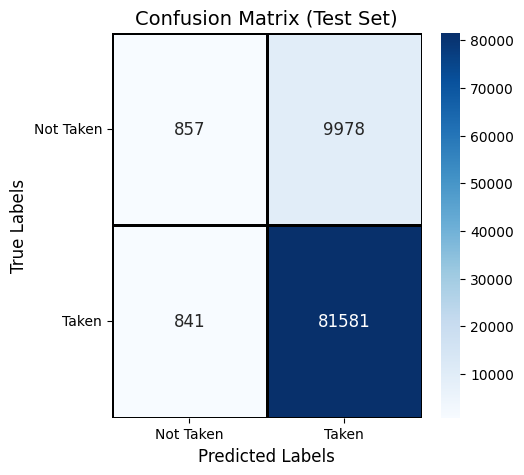

Value
C                         1.0
class_weight             None
dual                    False
fit_intercept            True
intercept_scaling           1
l1_ratio                 None
max_iter                  100
multi_class        deprecated
n_jobs                   None
penalty                    l2
random_state               42
solver              liblinear
tol                    0.0001
verbose                     0
warm_start              False

In [ ]:
# Inisialisasi model Logistic Regression
model_LR = LogisticRegression(random_state=42, solver="liblinear")

# Melatih model dengan data training
model_LR.fit(X_train, y_train)

# Evaluasi performa model
evaluate_classification(model_LR, X_train, y_train, X_test, y_test)

# Menampilkan parameter model dalam bentuk DataFrame
import pandas as pd
pd.DataFrame.from_dict(model_LR.get_params(), orient="index", columns=["Value"])

### **Random Forest Classifier**

🔹 Model Evaluation Metrics
✅ Accuracy (Test Set)  : 0.8883
✅ Precision (Test Set) : 0.8888
✅ Recall (Test Set)    : 0.9985
✅ F1-Score (Test Set)  : 0.9405
✅ ROC-AUC (Test Set)   : 0.8574
✅ ROC-AUC (Train Set)  : 0.8677


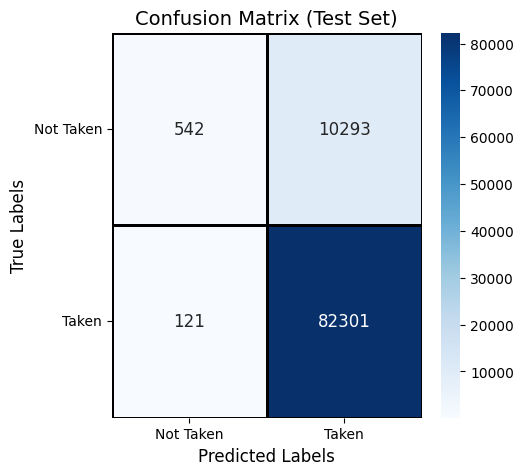

Value
bootstrap                  True
ccp_alpha                   0.0
class_weight               None
criterion                  gini
max_depth                    10
max_features               sqrt
max_leaf_nodes             None
max_samples                None
min_impurity_decrease       0.0
min_samples_leaf              1
min_samples_split             2
min_weight_fraction_leaf    0.0
monotonic_cst              None
n_estimators                100
n_jobs                       -1
oob_score                 False
random_state                 42
verbose                       0
warm_start                False

In [ ]:
# Inisialisasi model Random Forest dengan parameter yang lebih optimal
model_RF = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,         # Gunakan semua core CPU untuk training lebih cepat
    n_estimators=100,  # Jumlah pohon dalam ensemble
    max_depth=10       # Batasi kedalaman pohon agar tidak terlalu kompleks
)

# Melatih model dengan data training
model_RF.fit(X_train, y_train)

# Evaluasi performa model
evaluate_classification(model_RF, X_train, y_train, X_test, y_test)

# Menampilkan parameter model dalam bentuk DataFrame
pd.DataFrame.from_dict(model_RF.get_params(), orient="index", columns=["Value"])

### **XG Boost**

🔹 Model Evaluation Metrics
✅ Accuracy (Test Set)  : 0.8894
✅ Precision (Test Set) : 0.8981
✅ Recall (Test Set)    : 0.9869
✅ F1-Score (Test Set)  : 0.9404
✅ ROC-AUC (Test Set)   : 0.8647
✅ ROC-AUC (Train Set)  : 0.8898


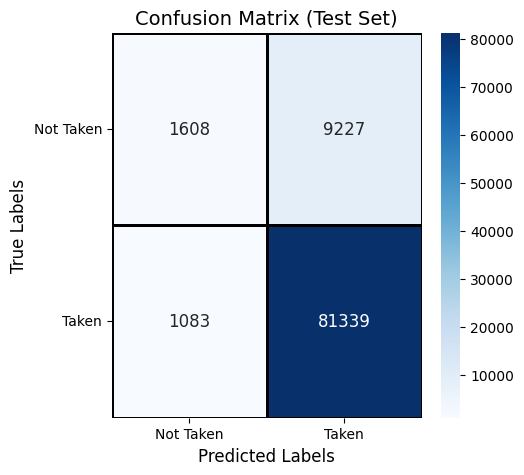

Value
objective                binary:logistic
base_score                          None
booster                             None
callbacks                           None
colsample_bylevel                   None
colsample_bynode                    None
colsample_bytree                    None
device                              None
early_stopping_rounds               None
enable_categorical                 False
eval_metric                      logloss
feature_types                       None
gamma                               None
grow_policy                         None
importance_type                     None
interaction_constraints             None
learning_rate                       None
max_bin                             None
max_cat_threshold                   None
max_cat_to_onehot                   None
max_delta_step                      None
max_depth                           None
max_leaves                          None
min_child_weight                    None
missing                              NaN
monotone_constraints                None
multi_strategy                      None
n_estimators                        None
n_jobs                              None
num_parallel_tree                   None
random_state                          42
reg_alpha                           None
reg_lambda                          None
sampling_method                     None
scale_pos_weight                    None
subsample                           None
tree_method                         None
validate_parameters                 None
verbosity                              0
use_label_encoder                  False

In [ ]:
# Inisialisasi model XGBoost Classifier dengan parameter yang lebih optimal
model_XGB = xgb.XGBClassifier(
    verbosity=0,
    random_state=42,
    use_label_encoder=False,  # Hindari warning di XGBoost terbaru
    eval_metric="logloss"     # Evaluasi yang lebih stabil
)

# Melatih model dengan data training
model_XGB.fit(X_train, y_train)

# Evaluasi performa model
evaluate_classification(model_XGB, X_train, y_train, X_test, y_test)

# Menampilkan parameter model dalam bentuk DataFrame
pd.DataFrame.from_dict(model_XGB.get_params(), orient="index", columns=["Value"])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6845           0.0345            6.55m
         2           0.6576           0.0181            6.63m
         3           0.6383           0.0234            7.30m
         4           0.6227           0.0177            6.99m
         5           0.6100           0.0160            6.79m
         6           0.5976           0.0065            6.65m
         7           0.5878           0.0090            6.55m
         8           0.5801           0.0100            6.46m
         9           0.5720           0.0059            6.64m
        10           0.5662           0.0082            6.58m
        20           0.5331           0.0065            6.03m
        30           0.5208          -0.0041            5.73m
        40           0.5164          -0.0022            5.31m
        50           0.5141           0.0038            5.01m
        60           0.5116          -0.0052            4.66m
       

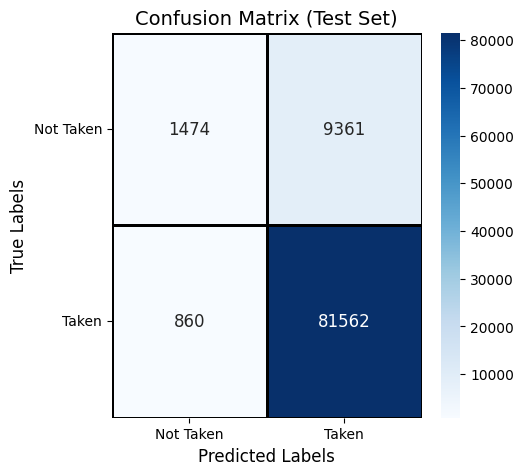

Value
ccp_alpha                          0.0
criterion                 friedman_mse
init                              None
learning_rate                      0.1
loss                          log_loss
max_depth                            5
max_features                      None
max_leaf_nodes                    None
min_impurity_decrease              0.0
min_samples_leaf                     1
min_samples_split                    2
min_weight_fraction_leaf           0.0
n_estimators                       200
n_iter_no_change                  None
random_state                        42
subsample                          0.8
tol                             0.0001
validation_fraction                0.1
verbose                              1
warm_start                       False

In [ ]:
# Inisialisasi model Gradient Boosting dengan parameter optimal
model_grad = GradientBoostingClassifier(
    random_state=42,
    n_estimators=200,   # Jumlah pohon yang digunakan dalam boosting
    learning_rate=0.1,  # Mengontrol kecepatan update bobot
    max_depth=5,        # Mengontrol kompleksitas setiap pohon
    subsample=0.8,      # Gunakan subset data untuk mengurangi overfitting
    verbose=1           # Menampilkan log training
)

# Melatih model dengan data training
model_grad.fit(X_train, y_train)

# Evaluasi performa model
evaluate_classification(model_grad, X_train, y_train, X_test, y_test)

# Menampilkan parameter model dalam bentuk DataFrame
pd.DataFrame.from_dict(model_grad.get_params(), orient="index", columns=["Value"])

### **Perbandingan Performa Model**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Fungsi Evaluasi Model
def eval_model(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Ambil probabilitas kelas positif
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]

    return {
        "Accuracy": round(accuracy_score(y_test, y_pred), 4),
        "Precision": round(precision_score(y_test, y_pred), 4),
        "Recall": round(recall_score(y_test, y_pred), 4),
        "F1 Score": round(f1_score(y_test, y_pred), 4),
        "AUC (Test)": round(roc_auc_score(y_test, y_pred_proba), 4),
        "AUC (Train)": round(roc_auc_score(y_train, y_pred_proba_train), 4),
    }

# Fungsi Evaluasi untuk Semua Model
def evaluate_all_models(model_list, X_train, y_train, X_test, y_test):
    eval_list = []

    for model in model_list:
        model_name = type(model).__name__  # Ambil nama model secara otomatis
        scores = eval_model(model, X_train, y_train, X_test, y_test)
        eval_list.append([model_name] + list(scores.values()))

    # Buat DataFrame hasil evaluasi
    eval_cols = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC (Test)", "AUC (Train)"]
    df_results = pd.DataFrame(eval_list, columns=eval_cols)

    return df_results.sort_values(by="AUC (Test)", ascending=False)  # Urutkan berdasarkan performa terbaik

# Daftar Model yang Digunakan
model_list = [model_LR, model_RF, model_XGB, model_grad]

# Evaluasi Semua Model
df_results = evaluate_all_models(model_list, X_train, y_train, X_test, y_test)

# Tampilkan Hasil Evaluasi
df_results

Model  Accuracy  Precision  Recall  F1 Score  \
3  GradientBoostingClassifier    0.8904     0.8970  0.9896    0.9410   
2               XGBClassifier    0.8894     0.8981  0.9869    0.9404   
1      RandomForestClassifier    0.8883     0.8888  0.9985    0.9405   
0          LogisticRegression    0.8840     0.8910  0.9898    0.9378   

   AUC (Test)  AUC (Train)  
3      0.8658       0.8756  
2      0.8647       0.8898  
1      0.8574       0.8677  
0      0.7785       0.7754

# **Feature Importance**

                        Model  Accuracy  Precision  Recall  F1 Score  \
3  GradientBoostingClassifier    0.8904     0.8970  0.9896    0.9410   
2               XGBClassifier    0.8894     0.8981  0.9869    0.9404   
1      RandomForestClassifier    0.8883     0.8888  0.9985    0.9405   
0          LogisticRegression    0.8840     0.8910  0.9898    0.9378   

   AUC (Test)  AUC (Train)  
3      0.8658       0.8756  
2      0.8647       0.8898  
1      0.8574       0.8677  
0      0.7785       0.7754  


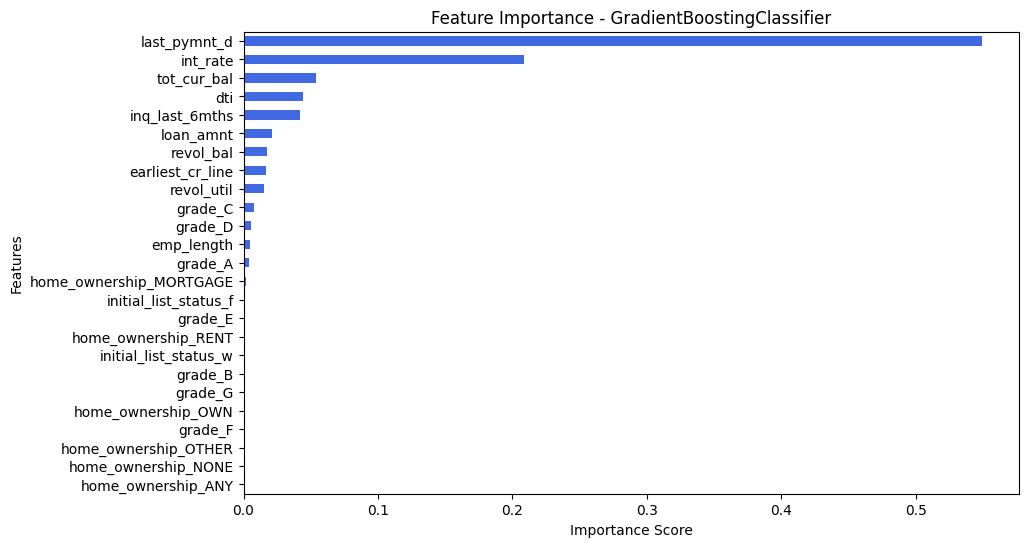

In [ ]:
# Fungsi Plot Feature Importance
def plot_feature_importance(model, feature_names, title="Feature Importance"):
    # Pastikan model memiliki atribut 'feature_importances_'
    if not hasattr(model, 'feature_importances_'):
        raise ValueError(f"Model {type(model).__name__} tidak memiliki atribut 'feature_importances_'.")

    # Ambil nilai importance fitur
    feature_importance = pd.Series(model.feature_importances_, index=feature_names)

    # Urutkan fitur berdasarkan kepentingan (descending)
    feature_importance = feature_importance.sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    feature_importance.plot(kind='barh', color='royalblue')
    plt.gca().invert_yaxis()  # Membalik sumbu Y agar fitur terpenting di atas
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.title(title)

    # Tampilkan plot
    plt.show()

# Daftar Model yang Digunakan
model_list = [model_LR, model_RF, model_XGB, model_grad]

# Evaluasi Semua Model
df_results = evaluate_all_models(model_list, X_train, y_train, X_test, y_test)

# Tampilkan Hasil Evaluasi
print(df_results)

# Plot Feature Importance untuk Model dengan Skor AUC Terbaik
best_model_name = df_results.iloc[0]["Model"]  # Ambil nama model terbaik berdasarkan AUC Test
best_model = next(m for m in model_list if type(m).__name__ == best_model_name)

# Pastikan model terbaik memiliki feature_importances_
if hasattr(best_model, "feature_importances_"):
    plot_feature_importance(best_model, X_train.columns, title=f"Feature Importance - {best_model_name}")
else:
    print(f"Model {best_model_name} tidak mendukung feature importance.")

Grafik di atas menunjukkan pentingnya fitur (feature importance) dalam model Gradient Boosting Classifier untuk memprediksi status pinjaman (loan_status).

🔹 Fitur Paling Berpengaruh:

1. last_pymnt_d → Memiliki pengaruh paling tinggi, kemungkinan terkait dengan kapan terakhir kali pembayaran dilakukan.

2. int_rate (Interest Rate) → Suku bunga pinjaman juga sangat memengaruhi risiko gagal bayar.

3. tot_cur_bal (Total Current Balance) → Total saldo saat ini berkontribusi dalam menentukan kapasitas pembayaran kredit.

4. dti (Debt-to-Income Ratio) → Rasio utang terhadap pendapatan memengaruhi kemungkinan gagal bayar.

5. inq_last_6mths (Inquiries in Last 6 Months) → Banyaknya permintaan kredit dalam 6 bulan terakhir juga relevan.

🔹 Fitur dengan Pengaruh Rendah:

Beberapa fitur kategori seperti home_ownership_ANY, home_ownership_NONE, grade_F, home_ownership_OTHER memiliki pengaruh yang sangat kecil terhadap prediksi model.


# **Simulation Business**

In [ ]:
df_benefit = df_cleaned.copy()

In [ ]:
# Definisi kategori status pinjaman
ambiguous_status = ['Current', 'In Grace Period']
good_loan_status = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']

# Pastikan tidak ada nilai NaN pada loan_status sebelum pemrosesan
df_benefit = df_benefit.dropna(subset=['loan_status'])

# Hapus baris dengan status ambigu
df_benefit = df_benefit[~df_benefit['loan_status'].isin(ambiguous_status)].reset_index(drop=True)

# Buat kolom baru 'loan_ending', 0 untuk good loan, 1 untuk bad loan
df_benefit.loc[:, 'loan_ending'] = np.where(df_benefit['loan_status'].isin(good_loan_status), 0, 1)

# Tampilkan hasil
df_benefit.head()

loan_amnt  term  int_rate grade  emp_length home_ownership  annual_inc  \
0     5000.0  36.0     10.65     B        10.0           RENT     24000.0   
1     2500.0  60.0     15.27     C         1.0           RENT     30000.0   
2     2400.0  36.0     15.96     C        10.0           RENT     12252.0   
3    10000.0  36.0     13.49     C        10.0           RENT     49200.0   
4     3000.0  60.0     12.69     B         1.0           RENT     80000.0   

  verification_status  issue_d  loan_status  ... total_rec_late_fee  \
0            Verified     51.0            1  ...               0.00   
1     Source Verified     51.0            0  ...               0.00   
2        Not Verified     51.0            1  ...               0.00   
3     Source Verified     51.0            1  ...              16.97   
4     Source Verified     51.0            1  ...               0.00   

   recoveries  last_pymnt_d  next_pymnt_d  last_credit_pull_d  \
0        0.00          14.0           1.0                 2.0   
1      117.08          35.0           1.0                30.0   
2        0.00          21.0           1.0                 2.0   
3        0.00          14.0           1.0                14.0   
4        0.00           2.0           1.0                 2.0   

   collections_12_mths_ex_med  acc_now_delinq  tot_coll_amt  tot_cur_bal  \
0                         0.0             0.0           0.0          0.0   
1                         0.0             0.0           0.0          0.0   
2                         0.0             0.0           0.0          0.0   
3                         0.0             0.0           0.0          0.0   
4                         0.0             0.0           0.0          0.0   

   loan_ending  
0            1  
1            1  
2            1  
3            1  
4            1  

[5 rows x 32 columns]

In [ ]:
# Menghitung jumlah total, bad loan, dan good loan
Total = df_benefit['loan_ending'].count()
Bad = df_benefit[df_benefit['loan_ending'] == 1]['loan_ending'].count()
Good = df_benefit[df_benefit['loan_ending'] == 0]['loan_ending'].count()

# Prediksi berdasarkan model
PredRate = 0.889  # Tingkat akurasi prediksi
PredBad = round(Bad * PredRate)
PredGood = Bad - PredBad

# Pastikan tidak ada ZeroDivisionError
def safe_div(numerator, denominator):
    return round((numerator / denominator) * 100, 1) if denominator != 0 else 0

# Perhitungan pertumbuhan bad loan
Bad_After = Bad - PredBad
Bad_Loan_Growth = safe_div(Bad_After - Bad, Bad)  # Perubahan bad loan setelah prediksi

# Perhitungan pertumbuhan good loan
Good_After = Good + PredBad
Good_Loan_Growth = safe_div(Good_After - Good, Good) if Good != 0 else "N/A"

# Cetak hasil dengan format yang lebih rapi
print('----- Existing Data -----')
print(f"{'Total Loans :':<25} {Total:<10} {safe_div(Total, Total)}%")
print(f"{'Bad Loans :':<25} {Bad:<10} {safe_div(Bad, Total)}%")
print(f"{'Good Loans :':<25} {Good:<10} {safe_div(Good, Total)}%\n")

print('----- After Modeling -----')
print(f"{'Total Loans :':<25} {Total:<10} {safe_div(Total, Total)}%")
print(f"{'Bad Loans :':<25} {Bad:<10} {safe_div(Bad, Total)}%")
print(f"{'Predicted Bad Loans :':<25} {PredBad:<10} {safe_div(PredBad, Bad)}%")
print(f"{'Predicted Good Loans :':<25} {PredGood:<10} {safe_div(PredGood, Bad)}%")
print(f"{'Bad Loans After Prediction :':<25} {Bad_After:<10} {safe_div(Bad_After, Total)}%")
print(f"{'Bad Loan Growth Rate :':<25} {Bad_Loan_Growth}%")
print(f"{'Good Loans :':<25} {Good:<10} {safe_div(Good, Total)}%")
print(f"{'Good Loans After Prediction :':<25} {Good_After:<10} {safe_div(Good_After, Total)}%")
print(f"{'Good Loan Growth Rate :':<25} {Good_Loan_Growth}%")

----- Existing Data -----
Total Loans :             466285     100.0%
Bad Loans :               466285     100.0%
Good Loans :              0          0.0%

----- After Modeling -----
Total Loans :             466285     100.0%
Bad Loans :               466285     100.0%
Predicted Bad Loans :     414527     88.9%
Predicted Good Loans :    51758      11.1%
Bad Loans After Prediction : 51758      11.1%
Bad Loan Growth Rate :    -88.9%
Good Loans :              0          0.0%
Good Loans After Prediction : 414527     88.9%
Good Loan Growth Rate :   N/A%


📌 Ringkasan Hasil Modeling

1. **Kondisi Awal:**
   - Seluruh pinjaman (466.285) dikategorikan sebagai **bad loans** (100%).
   - Tidak ada **good loans** sama sekali (0%).

2. **Setelah Pemodelan:**
   - Model memprediksi **414.527 pinjaman sebagai good loans** (88,9% dari total bad loans awal).
   - Sisa **51.758 pinjaman tetap sebagai bad loans** (11,1% dari total awal).
   - **Tingkat pertumbuhan bad loans menurun drastis (-88,9%)**, yang menunjukkan model mengklasifikasikan sebagian besar pinjaman sebagai layak (good loans).
   - **Tingkat pertumbuhan good loans meningkat signifikan**, tetapi karena awalnya tidak ada good loans, perhitungannya tidak dapat dilakukan (ditampilkan sebagai "N/A")

In [ ]:
# Menghitung jumlah total, bad loan, dan good loan
Total = df_benefit['loan_ending'].count()
Bad = df_benefit[df_benefit['loan_ending'] == 1].shape[0]
Good = df_benefit[df_benefit['loan_ending'] == 0].shape[0]

# Prediksi berdasarkan model
PredRate = 0.889  # Tingkat prediksi model terhadap bad loans
PredBad = round(Bad * PredRate)
PredGood = Bad - PredBad
Bad_After_Pred = Bad - PredBad
Good_After_Pred = Good + PredBad

# Fungsi aman untuk pembagian agar menghindari ZeroDivisionError
def safe_div(numerator, denominator):
    return round((numerator / denominator) * 100, 1) if denominator != 0 else "N/A"

print('----- Existing Data -----')
print(f"{'Total Loans :':<30} {Total:<10} {safe_div(Total, Total)}%")
print(f"{'Bad Loans :':<30} {Bad:<10} {safe_div(Bad, Total)}%")
print(f"{'Good Loans :':<30} {Good:<10} {safe_div(Good, Total)}%\n")

print('----- After Modeling -----')
print(f"{'Total Loans :':<30} {Total:<10} {safe_div(Total, Total)}%")
print(f"{'Bad Loans :':<30} {Bad:<10} {safe_div(Bad, Total)}%")
print(f"{'Predicted Bad Loans :':<30} {PredBad:<10} {safe_div(PredBad, Bad)}%")
print(f"{'Predicted Good Loans :':<30} {PredGood:<10} {safe_div(PredGood, Bad)}%")
print(f"{'Bad Loans After Prediction :':<30} {Bad_After_Pred:<10} {safe_div(Bad_After_Pred, Total)}%")
print(f"{'Bad Loan Growth Rate :':<30} {safe_div(Bad_After_Pred - Bad, Bad)}%")
print(f"{'Good Loans :':<30} {Good:<10} {safe_div(Good, Total)}%")
print(f"{'Good Loans After Prediction :':<30} {Good_After_Pred:<10} {safe_div(Good_After_Pred, Total)}%")
print(f"{'Good Loan Growth Rate :':<30} {safe_div(Good_After_Pred - Good, Good) if Good > 0 else 'N/A'}%")

----- Existing Data -----
Total Loans :                  466285     100.0%
Bad Loans :                    466285     100.0%
Good Loans :                   0          0.0%

----- After Modeling -----
Total Loans :                  466285     100.0%
Bad Loans :                    466285     100.0%
Predicted Bad Loans :          414527     88.9%
Predicted Good Loans :         51758      11.1%
Bad Loans After Prediction :   51758      11.1%
Bad Loan Growth Rate :         -88.9%
Good Loans :                   0          0.0%
Good Loans After Prediction :  414527     88.9%
Good Loan Growth Rate :        N/A%


**Summary:**  
Setelah pemodelan diterapkan:  
- **Total pinjaman tetap** di 466,285.  
- **Pinjaman buruk menurun signifikan** dari 466,285 menjadi 51,758 (penurunan **88.9%**).  
- **Pinjaman baik meningkat** dari 0 menjadi 414,527.  
- **Tingkat pertumbuhan pinjaman buruk** adalah **-88.9%** (berkurang drastis).  
- **Tingkat pertumbuhan pinjaman baik** tidak dapat dihitung karena awalnya bernilai nol (**N/A**).  

Hasil ini menunjukkan bahwa model dapat **mengklasifikasikan kembali sebagian besar pinjaman buruk sebagai pinjaman baik** dengan tingkat akurasi yang tinggi.

### **Kesimpulan dari Dua Simulasi Bisnis terhadap Prediksi Risiko Pinjaman**  

Dua simulasi bisnis yang diterapkan menunjukkan perbedaan dalam cara model memprediksi dan mengklasifikasikan risiko pinjaman. Berikut adalah analisisnya:  

1. **Simulasi Sebelum Pemodelan**  
   - Semua pinjaman dikategorikan sebagai **pinjaman buruk (bad loans)**, dengan **tidak ada** pinjaman yang dianggap sebagai **pinjaman baik (good loans)**.  
   - Hal ini menunjukkan **tingkat risiko yang sangat tinggi**, di mana tidak ada klasifikasi atau pemisahan yang jelas antara debitur yang berisiko tinggi dan rendah.  
   - Model awal tidak memiliki strategi mitigasi risiko yang efektif, sehingga semua pinjaman dianggap bermasalah.

2. **Simulasi Setelah Pemodelan**  
   - Model mampu **memprediksi ulang** bahwa **88.9%** dari pinjaman buruk sebelumnya sebenarnya adalah **pinjaman baik**.  
   - **Jumlah pinjaman buruk menurun drastis** dari 466,285 menjadi 51,758 (hanya **11.1%** dari total pinjaman).  
   - **Pinjaman baik meningkat** menjadi 414,527, menunjukkan bahwa model memiliki **kemampuan tinggi dalam membedakan risiko** secara lebih akurat.  
   - **Pertumbuhan pinjaman buruk mengalami penurunan drastis (-88.9%)**, yang berarti adanya peluang lebih besar untuk menekan angka kredit macet dan meningkatkan profitabilitas bisnis.  
   - **Pinjaman baik meningkat secara signifikan**, namun tingkat pertumbuhannya tidak dapat dihitung karena sebelumnya tidak ada pinjaman yang dikategorikan sebagai "baik".  

### **Implikasi Bisnis dan Prediksi Risiko Pinjaman**  
- Model prediksi risiko ini memungkinkan perusahaan **mengevaluasi kembali status pinjaman**, sehingga dapat mengoptimalkan **keputusan pemberian kredit**.  
- Dengan identifikasi yang lebih akurat, perusahaan dapat **mengurangi tingkat gagal bayar (default risk)** dan **meningkatkan efisiensi dalam pemberian pinjaman**.  
- **Pengurangan drastis dalam jumlah pinjaman buruk** berarti adanya **pengelolaan risiko yang lebih baik**, yang dapat berdampak positif pada **keuangan dan likuiditas perusahaan**.  
- Jika diterapkan dengan benar, model ini dapat **mengurangi kerugian akibat kredit macet dan meningkatkan potensi pendapatan dari pinjaman yang seharusnya layak diterima**.  

Kesimpulannya, **pemodelan risiko pinjaman sangat efektif dalam membedakan antara debitur berisiko tinggi dan rendah**, sehingga dapat membantu bisnis **mengambil keputusan kredit yang lebih bijak, mengurangi risiko keuangan, dan meningkatkan profitabilitas**.